## CNN for 3D Landmark prediction

#### Import libraries

In [4]:
# %%%%%%%%%%%%%%%%%%%% IMPORT RELEVANT LIBRARIES %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%matplotlib inline
import tkinter
import matplotlib.pyplot as plt
import SimpleITK as sitk
import gui
import utilities 
from ipywidgets import interact, fixed
import numpy as np
from enum import Enum
import os
# import pandas as pd
from IPython.display import display, HTML 
import os.path
from pathlib import Path
import time
from SimpleITK import MedianImageFilter

import SimpleITK as sitk
%matplotlib notebook
import json 
import shutil


### Load images


In [5]:
current_working_directory = os.getcwd()
print(current_working_directory)


/home/paulagmtz/TFM_PAULA_24/MONAI-UNET


Creamos la lista patients con los nombres de los pacientes encontrados en las carpetas de HGM_FILES

In [9]:
# ==========Directorios==================
path2data = '/home/paulagmtz/TFM_PAULA_24/mnt/data_ssd/DataPaula' + '/HGM_FILES'

# ============Patients==============
patients = []
for element in os.listdir(path2data):
    if ".ipynb_checkpoints" in element: # verifica si la cadena ".ipynb_checkpoints" está en la ruta del archivo
        print(f"Se omitirá el archivo {element}")
        continue
        
    for i in os.listdir(path2data +"/" + element):
        if ".ipynb_checkpoints" in i: # verifica si la cadena ".ipynb_checkpoints" está en la ruta del archivo
            print(f"Se omitirá el archivo {i}")
            continue
        
        patients.append(path2data + '/' + element + '/' + i)
        
del path2data, current_working_directory


Se omitirá el archivo .ipynb_checkpoints
Se omitirá el archivo .ipynb_checkpoints


**Grupo de test con nuevas imagenes**

In [4]:
# ==========Directorios==================
path2data = '/home/lcubero/HGM_TEST'

# ============Patients==============
patients_TEST = []

for element in os.listdir(path2data):
    if ".ipynb_checkpoints" in element: # verifica si la cadena ".ipynb_checkpoints" está en la ruta del archivo
        print(f"Se omitirá el archivo {element}")
        continue
        
    for i in os.listdir(path2data +"/" + element):
        if ".ipynb_checkpoints" in i: # verifica si la cadena ".ipynb_checkpoints" está en la ruta del archivo
            print(f"Se omitirá el archivo {i}")
            continue
        
        patients_TEST.append(path2data + '/' + element + '/' + i)
        


Se omitirá el archivo .ipynb_checkpoints


### Cargar landmarks guardados en .json


In [12]:
# list of strings
images = [x + '/IMAGENES/output_image_crop.nrrd' for x in patients]
diametro_TA = [x + '/LANDMARKS/diametro_TA.json'  for x in patients]
angulo_SP = [x + '/LANDMARKS/angulo_SP.json'  for x in patients]
OC = [x + '/LANDMARKS/OC.json'  for x in patients]

def load_landmarks(landmarks_file):
    landmarks = []
    with open(landmarks_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        for i in range(len(data['markups'][0]['controlPoints'])):
            # Get the (x, y, z) coordinates of the i-th landmark
            x = data['markups'][0]['controlPoints'][i]['position'][0]
            y = data['markups'][0]['controlPoints'][i]['position'][1]
            z = data['markups'][0]['controlPoints'][i]['position'][2]
            # Add the landmark coordinates to the list of landmarks
            landmarks.append([x, y, z])
    return landmarks

def load_all_landmarks(landmarks_list):
    all_landmarks = []
    for landmarks_file in landmarks_list:
        landmarks = load_landmarks(landmarks_file)
        all_landmarks.append(landmarks)
    # Convert the list of landmarks to a numpy array
    all_landmarks = np.array(all_landmarks)
    return all_landmarks

# Example usage: load the ground truth landmarks for multiple images from a list of JSON files 
diametro_TA = load_all_landmarks(diametro_TA)
angulo_SP = load_all_landmarks(angulo_SP)
OC = load_all_landmarks(OC)

# nuestra imagen de referencia (landmakrs han sido puestos en el centro para una mejor interpretación)
angulo_SP[5] = load_landmarks('/home/paulagmtz/TFM_PAULA_24/Referencias/ref_angulo_SP.json')
diametro_TA[5] = load_landmarks('/home/paulagmtz/TFM_PAULA_24/Referencias/ref_diametro_TA.json')
OC[5] = load_landmarks('/home/paulagmtz/TFM_PAULA_24/Referencias/ref_OC.json')


In [13]:
landmarks = [np.concatenate((angulo_SP[i], diametro_TA[i], OC[i])) for i in range(len(OC))]
landmarks[5]


array([[-194.75646237, -141.22746159,    8.38835604],
       [-153.04001065, -172.76963493,   24.19213867],
       [-114.11958767, -141.54244939,   11.38835604],
       [-206.80087357, -159.38781738,   98.84234619],
       [ -96.73629837, -160.28851318,  103.72540283],
       [-153.02900391, -181.06649227,   36.55970377],
       [-153.02900391, -138.3670104 ,  162.10892657]])

### Apply transformation on reference images and landmarks
Cogemos la imagen de referencia que hemos seleccionado

In [15]:
import h5py
import numpy as np
import SimpleITK as sitk

reference_image_translated = sitk.ReadImage('/home/paulagmtz/TFM_PAULA_24/Referencias/reference5_cropped.nrrd', sitk.sitkFloat32)
reference_image_translated.GetOrigin()

(0.0, 0.0, 0.0)

# Segmentación de pelvis basado en intensidad

En una escala de unidades Hounsfield, el aire tiene un valor de aproximadamente -1000 HU, el agua tiene un valor cercano a 0 HU, y los tejidos óseos suelen tener valores positivos.

En el caso del hueso de pelvis, los valores CT de normal pueden oscilar en un rango amplio, pero por lo general se encuentran en el rango de aproximadamente 200 a 1000 HU.

* "Hounsfield units pelvis bone CT"

In [16]:
gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
gaussian.SetSigma(float(3))

smoothed_image = gaussian.Execute(reference_image_translated)
smoothed_image_array = sitk.GetArrayFromImage(smoothed_image)


plt.figure()
plt.hist(smoothed_image_array.flatten(), bins=256, color='r', alpha=0.5)
plt.title('Image 1 Histogram')

u_inf = 150
u_sup = 1050

smoothed_image_array[smoothed_image_array < u_inf ] = min(smoothed_image_array.flatten())
smoothed_image_array[smoothed_image_array > u_sup ] = min(smoothed_image_array.flatten())


plt.figure()
plt.hist(smoothed_image_array.flatten(), bins=256, color='r', alpha=0.5)
plt.title('Image 1 Histogram')
plt.xlim(140, 1100)
plt.ylim(0, 150000)

reference_gauss_hist = sitk.GetImageFromArray(smoothed_image_array)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
foreground_mask = reference_gauss_hist>-1000

# Apply Dilation
kernel_radius = 5
bmcif = sitk.BinaryDilateImageFilter() #  BinaryMorphologicalClosingImageFilter, BinaryDilateImageFilter
bmcif.SetKernelType(sitk.sitkBall) # BinaryErodeImageFilter, BinaryMorphologicalOpeningImageFilter 
bmcif.SetKernelRadius(kernel_radius)

mask_dilation = bmcif.Execute(foreground_mask)

# Apply Erosion
kernel_radius = 2
bmcif = sitk.BinaryErodeImageFilter() # BinaryErodeImageFilter, BinaryMorphologicalClosingImageFilter, BinaryDilateImageFilter
bmcif.SetKernelType(sitk.sitkBall)
bmcif.SetKernelRadius(kernel_radius)

mask_dil_open = bmcif.Execute(mask_dilation)


# le aplicamos la máscara a la imagen sin filtro gaussiano
reference_image_hist = sitk.GetArrayFromImage(reference_image_translated)
reference_image_hist_array = sitk.GetImageFromArray(reference_image_hist)

masked_ref_image = sitk.Mask(reference_image_hist_array, sitk.Cast(mask_dil_open, sitk.sitkInt32), maskingValue=0, outsideValue=0)

gui.MultiImageDisplay(image_list = [reference_image_hist_array, mask_dil_open, masked_ref_image],                   
                      title_list = ['Original image', 'Binary mask', 'Image after applying binary mask',], figure_size=(12,8), window_level_list=[[835,362], [0.2,0.75], [835,362]]);


RuntimeError: Exception thrown in SimpleITK Mask: /tmp/SimpleITK/Code/Common/include/sitkDualMemberFunctionFactory.hxx:190:
sitk::ERROR: Pixel type: 32-bit float is not supported in 3D byN3itk6simple15MaskImageFilterE

### Apply it to all the images


In [22]:
masked_images = []

u_inf = 150
u_sup = 1030
    

for i, patient in enumerate(patients):
    
    # load image
    image_file = patient + '/IMAGENES/output_image_crop.nrrd' 
    image = sitk.ReadImage(image_file, sitk.sitkFloat32)
    
    # apply gaussian filter to image
    gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
    gaussian.SetSigma(float(2))
    smoothed_image = gaussian.Execute(image)
    smoothed_image_array = sitk.GetArrayFromImage(smoothed_image)
    
    
    # hist threshold
    smoothed_image_array[smoothed_image_array < u_inf ] = min(smoothed_image_array.flatten())
    smoothed_image_array[smoothed_image_array > u_sup ] = min(smoothed_image_array.flatten())

    image_gauss_hist = sitk.GetImageFromArray(smoothed_image_array)


    # initial mask
    foreground_mask = image_gauss_hist > -1000

    # Apply Dilation
    kernel_radius = 5
    bmcif = sitk.BinaryDilateImageFilter() #  BinaryMorphologicalClosingImageFilter, BinaryDilateImageFilter
    bmcif.SetKernelType(sitk.sitkBall) # BinaryErodeImageFilter, BinaryMorphologicalOpeningImageFilter 
    bmcif.SetKernelRadius(kernel_radius)

    mask_dilation = bmcif.Execute(foreground_mask)

    # Apply Erosion
    kernel_radius = 2
    bmcif = sitk.BinaryErodeImageFilter() # BinaryErodeImageFilter, BinaryMorphologicalClosingImageFilter, BinaryDilateImageFilter
    bmcif.SetKernelType(sitk.sitkBall)
    bmcif.SetKernelRadius(kernel_radius)

    mask_dil_open = bmcif.Execute(mask_dilation)
    mask_dil_open.CopyInformation(image)

    # le aplicamos la máscara a la imagen sin filtro gaussiano
    masked_ref_image = sitk.Mask(image, sitk.Cast(mask_dil_open, sitk.sitkInt32), maskingValue=0, outsideValue=0)
    
    # SAVE RESULTS
    sitk.WriteImage(masked_ref_image, './DATA_TFM/MASKED_IMAGES/' + str(patient.split("/")[-1]) + '_mask_image.nrrd' )
    

Box(children=(IntSlider(value=108, description='image slice:', max=217), IntSlider(value=108, description='ima…

<IPython.core.display.Javascript object>


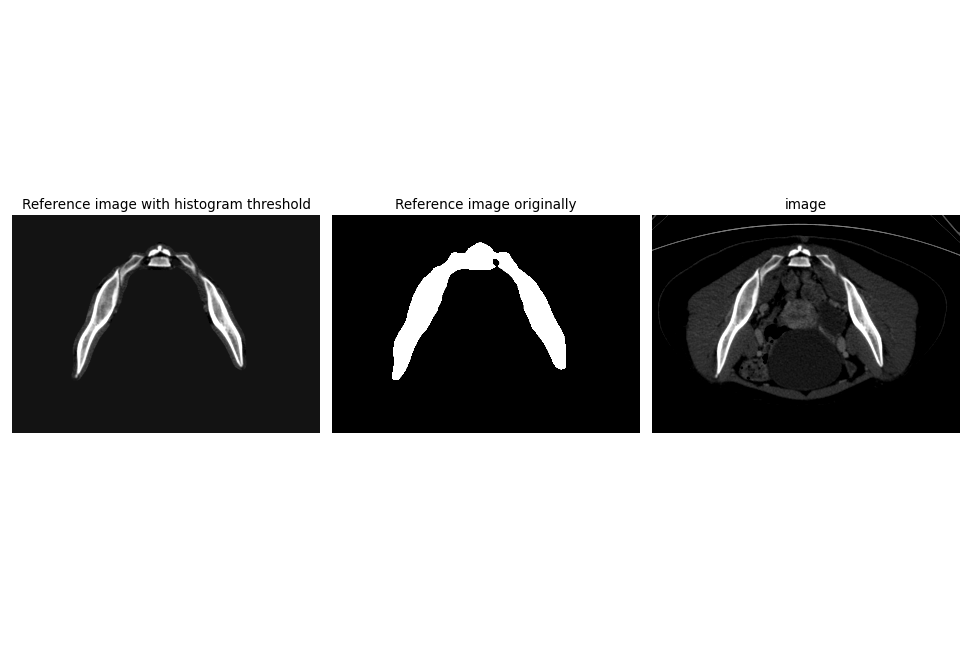

In [23]:
gui.MultiImageDisplay(image_list = [masked_ref_image, mask_dil_open, image],                   
                      title_list = ['Reference image with histogram threshold', 'Reference image originally', 'image'], figure_size=(12,8), window_level_list=[[835,362], [0.2,0.75], [835,362]]);

In [25]:
# Same but for reference image
i=5
image = reference_image_translated
u_inf = 150
u_sup = 1050

# apply gaussian filter to image
gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
gaussian.SetSigma(float(2))
smoothed_image = gaussian.Execute(image)
smoothed_image_array = sitk.GetArrayFromImage(smoothed_image)


# hist threshold
smoothed_image_array[smoothed_image_array < u_inf ] = min(smoothed_image_array.flatten())
smoothed_image_array[smoothed_image_array > u_sup ] = min(smoothed_image_array.flatten())

image_gauss_hist = sitk.GetImageFromArray(smoothed_image_array)


# initial mask
foreground_mask = image_gauss_hist > -1000

# Apply Dilation
kernel_radius = 5
bmcif = sitk.BinaryDilateImageFilter() #  BinaryMorphologicalClosingImageFilter, BinaryDilateImageFilter
bmcif.SetKernelType(sitk.sitkBall) # BinaryErodeImageFilter, BinaryMorphologicalOpeningImageFilter 
bmcif.SetKernelRadius(kernel_radius)

mask_dilation = bmcif.Execute(foreground_mask)

# Apply Opening
kernel_radius = 2
bmcif = sitk.BinaryErodeImageFilter() # BinaryErodeImageFilter, BinaryMorphologicalClosingImageFilter, BinaryDilateImageFilter
bmcif.SetKernelType(sitk.sitkBall)
bmcif.SetKernelRadius(kernel_radius)

mask_dil_open = bmcif.Execute(mask_dilation)
mask_dil_open.CopyInformation(image)

# le aplicamos la máscara a la imagen sin filtro gaussiano
masked_ref_image = sitk.Mask(image, sitk.Cast(mask_dil_open, sitk.sitkInt32), maskingValue=0, outsideValue=0)

# SAVE RESULTS
sitk.WriteImage(masked_ref_image, './DATA_TFM/MASKED_IMAGES/' + str(patients[i].split("/")[-1]) + '_mask_image.nrrd' )


Box(children=(IntSlider(value=138, description='image slice:', max=277), IntSlider(value=138, description='ima…

<IPython.core.display.Javascript object>


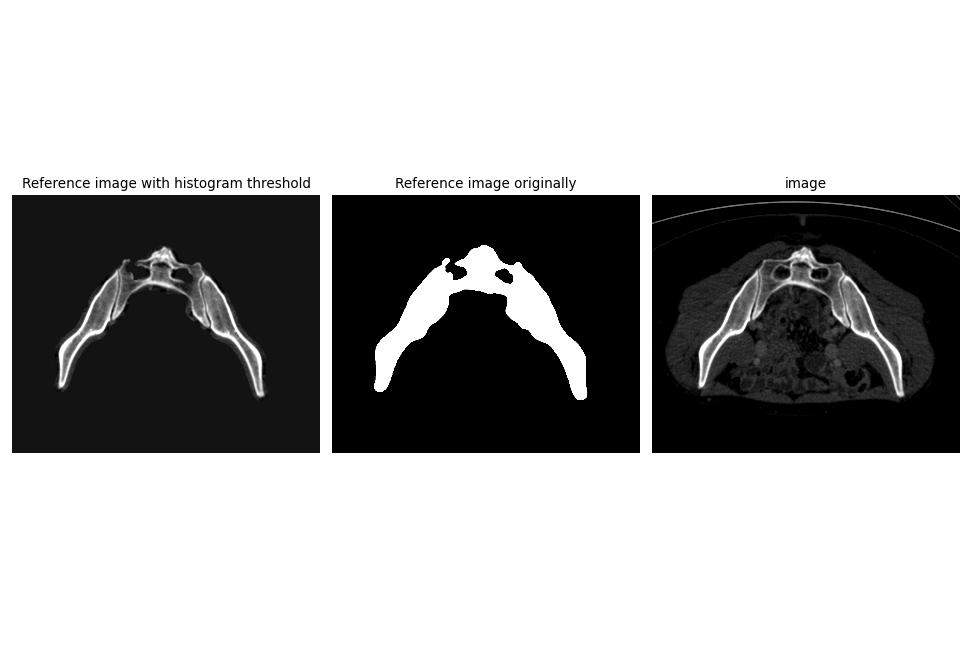

In [26]:
# '/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_10643160_ANTROP/image_registered.nrrd'

gui.MultiImageDisplay(image_list = [masked_ref_image, mask_dil_open, image],                   
                      title_list = ['Reference image with histogram threshold', 'Reference image originally', 'image'], figure_size=(12,8), window_level_list=[[835,362], [0.2,0.75], [835,362]]);

**Cargamos las imágenes con la pelvis segmentada que han sido guardadas en la carpeta MASKED_IMAGES**

In [9]:
masked_images = []
masked_landmarks = landmarks

folder_path = './DATA_TFM/MASKED_IMAGES/' # Replace with the actual folder path


for i, patient in enumerate(patients):
    
    file_path = os.path.join(folder_path, str(patients[i].split("/")[-1]) + '_mask_image.nrrd')
    
    if ".ipynb_checkpoints" in file_path: # verifica si la cadena ".ipynb_checkpoints" está en la ruta del archivo
        print(f"Se omitirá el archivo {file_path}")
        continue
        
    masked_images.append(sitk.ReadImage(file_path, sitk.sitkFloat32))



### Padding the reference image to reach the desired size for registration

In [18]:
# Load the input image
# input_image = masked_images[5]
input_image =reference_image_translated
# Define the desired size
desired_size = (582, 444, 280)

# Compute the amount of padding needed for each dimension
pad_x = max(desired_size[0] - input_image.GetSize()[0], 0)
pad_y = max(desired_size[1] - input_image.GetSize()[1], 0)
pad_z = max(desired_size[2] - input_image.GetSize()[2], 0)

# Define the amount of padding for each side of the image
lower_pad = (pad_x//2, pad_y//2, pad_z//2)
upper_pad = (pad_x - lower_pad[0], pad_y - lower_pad[1], pad_z - lower_pad[2])

# Create the filter for zero-padding the image
padding_filter = sitk.ConstantPadImageFilter()

# Set the padding value to 0
padding_value = 0

# Apply the padding filter to the input image
padded_image = sitk.ConstantPad(input_image, lower_pad, upper_pad, padding_value)
padded_image.SetOrigin(input_image.GetOrigin())


print('\Resize image')
print('Size:', input_image.GetSize())

print('\nResize + padding image')
print('Size:', padded_image.GetSize())

ct_window_level_norm = [835,362]

padded_image.SetOrigin((0, 0, 0))

gui.MultiImageDisplay(image_list = [input_image , padded_image],                   
                      title_list = ['masked reference', 'masked reference + padding'], figure_size=(8,5), window_level_list=[ct_window_level_norm, ct_window_level_norm]);


\Resize image
Size: (512, 430, 278)

Resize + padding image
Size: (582, 444, 280)


Box(children=(IntSlider(value=138, description='image slice:', max=277), IntSlider(value=139, description='ima…

<IPython.core.display.Javascript object>

In [30]:
masked_landmarks[5][:, 0] = np.add(masked_landmarks[5][:, 0]*(-1), 35*masked_images[5].GetSpacing()[0])  # Suma 2 al primer valor de cada item en el array
masked_landmarks[5][:, 1] = np.add(masked_landmarks[5][:, 1]*(-1), 2*masked_images[5].GetSpacing()[1])  # Suma 2 al primer valor de cada item en el array
masked_landmarks[5][:, 2] = np.add(masked_landmarks[5][:, 2], 1*masked_images[5].GetSpacing()[2])  # Suma 1 al segundo valor de cada item en el array
masked_landmarks[5]/masked_images[5].GetSpacing()

array([[346.61033979, 227.96393855,   9.38835604],
       [279.86401705, 278.43141589,  25.19213867],
       [217.59134027, 228.46791902,  12.38835604],
       [365.88139771, 257.02050781,  99.84234619],
       [189.77807739, 258.46162109, 104.72540283],
       [279.84640625, 291.70638763,  37.55970377],
       [279.84640625, 223.38721665, 163.10892657]])

# Registrations 

With registration we will be able to get the same voxel size as the reference image. Also we will be using the initial transformaation based on geometry centers as our images have been previously cropped based on the same region of interest and this will reduce the time to register the images.

For having the same spacing (voxel size) and same origin and orientation in all images.

* Take into account that in order to apply the transformation to the landmarks we should apply the inverse transform.
* Also for the representation sitk and slicer have some differences, we should multiply *(1, -1, 1) as LR axes are switched
* Also we have to divide the values by the spacing in order to have pixels

## TRANSLATION (REGISTRATION)

In [ ]:
import SimpleITK as sitk
import gui
import registration_gui as rgui

import numpy as np
import os

transforms_matrix=[]
translated_landmarks_matrix=[]

final_transformed_images=[]

# tras el padding debemos reajustar el origen y los landmarks
padded_image.SetOrigin((0,0,0))

resampled_images = []

masked_images[5]= resampled_normalized_img_ref # comparamos entre imágenes normalizadas

for i, patient in enumerate(patients):
    
    # _________RESAMPLED IMAGES______________
    # Lee la imagen
    resampled_image = masked_images[i]

    # Normalize the image
    resampled_array = sitk.GetArrayFromImage(resampled_image)
    
    # Define the normalization range
    norm_min = 0
    norm_max = np.max(resampled_array)
    
    resampled_array = (resampled_array - norm_min) / (norm_max - norm_min)

    # Append the numpy array to the list of resampled images
    resampled_normalized_img = sitk.GetImageFromArray(resampled_array)
    resampled_normalized_img.CopyInformation(resampled_image)
    
    #_________REGISTRATION_________
    fixed_image= masked_images[5] # Imagen de referencia
    moving_image = resampled_normalized_img # valores de 0 a 1
    print('\nPATIENT:',i, moving_image.GetOrigin())
    
    translated_landmarks = [masked_landmarks[i][j]-np.array(moving_image.GetOrigin()) for j in range(len(masked_landmarks[i]))]#     
    moving_image.SetOrigin(fixed_image.GetOrigin()) # mismo origen para las dos, mejor registro
    
    print(translated_landmarks)
    # [masked_landmarks[i][j]- (np.array(masked_images[17].GetOrigin())) for j in range(len(masked_landmarks[i]))]
    
    ## -------REGISTRATION---------
    initial_transform = sitk.TranslationTransform(fixed_image.GetDimension())

    # Registration settings
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-4, convergenceWindowSize=5)
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method))

    # Apply the final transformation to the moving image
    final_transform = registration_method.Execute(fixed_image, moving_image)
    final_transformed_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0)
    
    final_transformed_images.append(final_transformed_image)
    transforms_matrix.append(final_transform)
    
    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    
    transformada_inv = final_transform.GetInverse()

    # print(transformada_inv)
    # Apply transformation of the registartion and save the new landmarks in a matrix 
    landmarks_registered= [transformada_inv.TransformPoint(point) for point in np.array(translated_landmarks)]
    
    #translated_landmarks_matrix.append(landmarks_registered// np.array((padded_image.GetSpacing()))*(1,-1,1))
    translated_landmarks_matrix.append(landmarks_registered/ np.array((fixed_image.GetSpacing()))*(-1,-1,1))
    
    print('En px para el paciente',i , landmarks_registered / np.array((fixed_image.GetSpacing()))*(-1,-1,1) )
    



Box(children=(IntSlider(value=139, description='image slice:', max=279), IntSlider(value=139, description='ima…

<IPython.core.display.Javascript object>


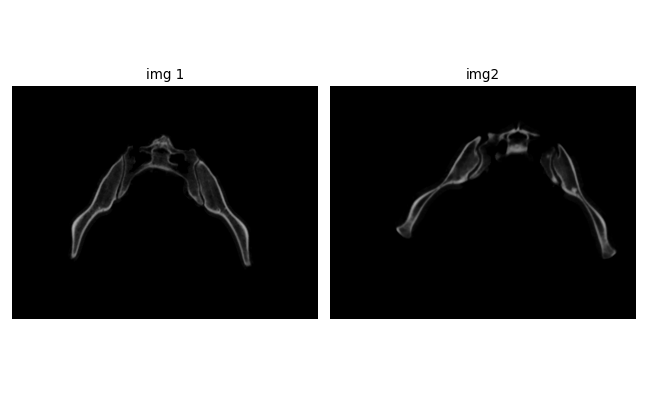

In [116]:
# revisar paciente 9,  33, 35,
ct_window_level_norm = [835,362]
gui.MultiImageDisplay(image_list = [final_transformed_images[5] , final_transformed_images[31]],                   
                      title_list = ['img 1','img2'], figure_size=(8,5), window_level_list=[[1.5,0.75], [1.5,0.75]]);


### SAVE THE REGISTRATION RESULTS

In [104]:
import SimpleITK

final_transformed_images[5]= resampled_normalized_img_ref #la primera es la de referencia
landmarks_registration= []

for i, patient in enumerate(patients):
    
    # Guardamos la transformada
    if (i==5):
        transformada = sitk.Transform(3, sitk.sitkIdentity)
        landmarks_reg = masked_landmarks[5]/ np.array(padded_image.GetSpacing())
        
    else:
        transformada = transforms_matrix[i]
        landmarks_reg = translated_landmarks_matrix[i]
        
    imagen_registrada = final_transformed_images[i]
    sitk.WriteImage(imagen_registrada, patient + '/image_registered.nrrd')
    
    # save landmark
    np.savetxt(patient + '/landmarks_registered.txt', landmarks_reg)

    transform_location = patient + '/transform_registered.txt' 
    sitk.WriteTransform(transformada, transform_location)
    
    

## Read the registered landmarks and images
En algunos casos los landmarks L3 L4 o L5 L6 estaban cambiados (depende del orden en el que hemos anotado las imágenes)

In [41]:
# EJECUTAR PRIMERA VEZ TRAS REGISTRO

labels = []
final_transformed_images = []

for i, patient in enumerate(patients):
    landmark_registered = np.loadtxt(patient + '/landmarks_registered.txt')
    
    if i in [3, 43, 58]:
        temp = landmark_registered[4].copy()
        landmark_registered[4] = landmark_registered[3]
        landmark_registered[3] = temp
        np.savetxt(patient + '/landmarks_registered.txt', landmark_registered)

        
    if i in [17, 40, 49]:
        temp = landmark_registered[5].copy()
        landmark_registered[5] = landmark_registered[6]
        landmark_registered[6] = temp
        np.savetxt(patient + '/landmarks_registered.txt', landmark_registered)

        
    image_registered = sitk.ReadImage(patient + '/image_registered.nrrd', sitk.sitkFloat32)
    labels_round2 = np.array([[round(value, 2) for value in sublist] for sublist in landmark_registered])

    labels.append(labels_round2)
    final_transformed_images.append(image_registered)
    
    
    # SAVE CHANGES
    



 0 [[345.03 219.08  10.29]
 [282.13 285.44  15.94]
 [213.4  226.12   9.6 ]
 [377.73 239.41  90.6 ]
 [178.42 245.86  90.6 ]
 [286.52 297.28  32.75]
 [285.34 226.1  150.74]]

 1 [[392.86 193.53   6.06]
 [340.08 241.8   20.04]
 [282.36 196.39   1.06]
 [435.79 198.49  90.99]
 [240.83 195.87  91.63]
 [340.76 253.61  31.4 ]
 [340.76 202.02 170.91]]

 2 [[365.13 160.69  18.99]
 [297.53 215.38  36.28]
 [223.02 165.16  19.4 ]
 [373.85 183.56  99.78]
 [211.07 174.68  99.78]
 [290.08 232.95  57.13]
 [290.08 163.99 178.93]]

 3 [[307.61 215.25  14.87]
 [239.31 249.74  22.51]
 [177.15 202.41  14.32]
 [339.13 245.14 101.66]
 [141.86 233.42 102.79]
 [236.76 267.15  35.4 ]
 [237.39 260.58 160.67]]

 4 [[454.01 193.04   2.05]
 [387.26 251.04  18.65]
 [322.91 203.23   4.12]
 [485.38 214.06  89.99]
 [282.97 227.08  89.99]
 [388.29 270.99  36.95]
 [388.29 219.62 161.6 ]]

 5 [[346.61 227.96   9.39]
 [279.86 278.43  25.19]
 [217.59 228.47  12.39]
 [365.88 257.02  99.84]
 [189.78 258.46 104.73]
 [279.85 29

In [42]:
sitk.WriteImage(resampled_normalized_img_ref, patients[5] + '/image_registered.nrrd') # ejecutar solo una vez al realizar el registro

NameError: name 'resampled_normalized_img_ref' is not defined

### **Una vez el registro se ha llevado a cabo, ejecutar únicamente estas celdas para cargar los archivos**

In [8]:
# NO HACE FALTA EJECUTAR REGISTRO 
labels_names= []
images_names=[]

for i, patient in enumerate(patients):

    labels_names.append(patient + '/landmarks_registered.txt')
    images_names.append(patient + '/image_registered.nrrd')
    
    
    # SAVE CHANGES

In [9]:
### Eliminamos imagenes que no cumplen la resolucion minima en el registro

del images_names[66] # run solo una vez despues de la anterior celda
del labels_names[66]

del images_names[45] # run solo una vez despues de la anterior celda
del labels_names[45]

del images_names[21] # run solo una vez despues de la anterior celda
del labels_names[21]

In [10]:
# Imagenes de test del nuevo set de imagenes 

labels_names_TEST= []
images_names_TEST=[]

for i, patient in enumerate(patients_TEST):
    
    labels_names_TEST.append(patient + '/landmarks_registered.txt')
    images_names_TEST.append(patient + '/image_registered.nrrd')
    

In [11]:
images_names = np.concatenate((images_names, images_names_TEST))
labels_names = np.concatenate((labels_names, labels_names_TEST))


### Creamos los archivos de entrenamiento

### Train test split BEFORE RESIZING

In [12]:
from sklearn.model_selection import train_test_split

/home/lcubero/miniconda3/envs/tf_env_copy/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
# train is 80% of the entire data set IMAGENES
classes = []
for i in range(len(images_names)):
    
    if 'ANTRO' in images_names[i]:
        classes.append(0)
    elif 'ANDR' in images_names[i]:
        classes.append(1)
    elif 'GIN' in images_names[i]:
        classes.append(2)
    elif 'PLAT' in images_names[i]:
        classes.append(3)
    
print('Total:', pd.DataFrame(classes).value_counts())
        
X_train, X_test, Y_train, Y_test = train_test_split(images_names, labels_names, test_size=0.25, random_state=42, stratify = classes)

for i, patient in enumerate(X_train): 
    path = X_train[i]
    directory = os.path.dirname(path)
    basename = os.path.basename(directory)
    sitk.WriteImage(sitk.ReadImage(X_train[i]), './DownloadTRAIN/'+ basename+'.nrrd')
    
classes = []
for i in range(len(X_train)):
    if 'ANTRO' in X_train[i]:
        classes.append(0)
    elif 'ANDR' in X_train[i]:
        classes.append(1)
    elif 'GIN' in X_train[i]:
        classes.append(2)
    elif 'PLAT' in X_train[i]:
        classes.append(3)

classes_test = []
for i in range(len(X_test)):
    if 'ANTRO' in X_test[i]:
        classes_test.append(0)
    elif 'ANDR' in X_test[i]:
        classes_test.append(1)
    elif 'GIN' in X_test[i]:
        classes_test.append(2)
    elif 'PLAT' in X_test[i]:
        classes_test.append(3)

print('\nTest set:\n', pd.DataFrame(classes_test).value_counts())

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify = classes)
y_train = Y_train

classes_train = []
for i in range(len(X_train)):
    if 'ANTRO' in X_train[i]:
        classes_train.append(0)
    elif 'ANDR' in X_train[i]:
        classes_train.append(1)
    elif 'GIN' in X_train[i]:
        classes_train.append(2)
    elif 'PLAT' in X_train[i]:
        classes_train.append(3)
print('\nTrain set:\n', pd.DataFrame(classes_train).value_counts())


classes_val = []
for i in range(len(Y_val)):
    if 'ANTRO' in Y_val[i]:
        classes_val.append(0)
    elif 'ANDR' in Y_val[i]:
        classes_val.append(1)
    elif 'GIN' in Y_val[i]:
        classes_val.append(2)
    elif 'PLAT' in Y_val[i]:
        classes_val.append(3)
print('\nValidation set:\n', pd.DataFrame(classes_val).value_counts())



df = pd.DataFrame({'Images train resized': X_test, 'Labels train resized': Y_test})

# Display the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
 
# All dataframes hereafter reflect these changes.
display(df.head(10))

Total: 0    48
2    31
1     5
3     3
Name: count, dtype: int64

Test set:
 0    12
2     8
1     1
3     1
Name: count, dtype: int64

Train set:
 0    27
2    17
1     3
3     1
Name: count, dtype: int64

Validation set:
 0    9
2    6
1    1
3    1
Name: count, dtype: int64


,Images train resized,Labels train resized
0,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_802351174_ANTROP/image_registered.nrrd,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_802351174_ANTROP/landmarks_registered.txt
1,/mnt/data_ssd/DataPaula/HGM_FILES/PLATIPELOIDE/P_2376530_PLATI/image_registered.nrrd,/mnt/data_ssd/DataPaula/HGM_FILES/PLATIPELOIDE/P_2376530_PLATI/landmarks_registered.txt
2,/mnt/data_ssd/DataPaula/HGM_FILES/GINECOIDE/P_1612231_GIN/image_registered.nrrd,/mnt/data_ssd/DataPaula/HGM_FILES/GINECOIDE/P_1612231_GIN/landmarks_registered.txt
3,/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_1059692_ANTROP/image_registered.nrrd,/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_1059692_ANTROP/landmarks_registered.txt
4,/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_2111864_ANTROP/image_registered.nrrd,/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_2111864_ANTROP/landmarks_registered.txt
5,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_803268479_ANTROP/image_registered.nrrd,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_803268479_ANTROP/landmarks_registered.txt
6,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_801379696_ANTROP/image_registered.nrrd,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_801379696_ANTROP/landmarks_registered.txt
7,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_1856243_ANTROP/image_registered.nrrd,/home/lcubero/HGM_TEST/ANTROPOIDE_2/P_1856243_ANTROP/landmarks_registered.txt
8,/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_10550586_ANTROP/image_registered.nrrd,/mnt/data_ssd/DataPaula/HGM_FILES/ANTROPOIDE/P_10550586_ANTROP/landmarks_registered.txt
9,/mnt/data_ssd/DataPaula/HGM_FILES/GINECOIDE/P_2146763_GIN/image_registered.nrrd,/mnt/data_ssd/DataPaula/HGM_FILES/GINECOIDE/P_2146763_GIN/landmarks_registered.txt


## Resize

In [19]:
for i, patient in enumerate(images_names):
     
    # cargamos los labels y las imagenes
    image_registered = sitk.ReadImage(images_names[i], sitk.sitkFloat32)
    landmark_registered = np.loadtxt(labels_names[i])
    
    # for resizing we have image + landmarks
    labels = np.array([[value for value in sublist] for sublist in landmark_registered])    
    input_image = image_registered[:,:,:210] # (582, 444, 280)

    input_size = input_image.GetSize()

    # Define the new size of the image with reduced number of slices
    new_size = [input_size[0]//3, input_size[1]//3, input_size[2]//2] # change "//2" to the desired reduction factor

    # Define the new spacing of the image to preserve the physical size
    original_spacing = input_image.GetSpacing()
    
    new_spacing = [input_image.GetSpacing()[0]*3, input_image.GetSpacing()[1]*3, input_image.GetSpacing()[2]*2] # change "*2" to the inverse of the reduction factor

    # Resample the input image with the new size and spacing
    final_transformed_resampled = sitk.Resample(input_image, new_size, sitk.Transform(), sitk.sitkLinear, input_image.GetOrigin(), new_spacing, input_image.GetDirection(), 0.0, input_image.GetPixelID())
    
    # Escalar las coordenadas de los landmarks ---------------
    valor= ((np.array(labels / np.array((3,3,2)))))
    
    # SAVE RESULTS    
    sitk.WriteImage(final_transformed_resampled, './resized_masks/' + patient.split('/')[-2] + '.nrrd') # SAVE IMAGE
    np.savetxt('./resized_masks/'+ patient.split('/')[-2] +'.txt', np.array([[round(value, 2) for value in sublist] for sublist in valor]).reshape(-1))
    


In [14]:
x_resized = []
y_resized= []

for i, patient in enumerate(images_names):
    
    x_resized.append('./resized_masks/' + patient.split('/')[-2] + '.nrrd')
    y_resized.append('./resized_masks/'+ patient.split('/')[-2] +'.txt')  #np.round    .reshape(n,3) # y ademas lo pasamos a pixeles            


## Train test split AFTER RESIZING

In [15]:
# train is 75% of the entire data set IMAGENES
classes = []
for i in range(len(y_resized)):
    if 'ANTRO' in y_resized[i]:
        classes.append(0)
    elif 'ANDR' in y_resized[i]:
        classes.append(1)
    elif 'GIN' in y_resized[i]:
        classes.append(2)
    elif 'PLAT' in y_resized[i]:
        classes.append(3)
    
print('Total:', pd.DataFrame(classes).value_counts())
        
X_train_r, X_test_resized, Y_train_r, Y_test_resized = train_test_split(x_resized, y_resized, test_size=0.25, random_state=42, stratify = classes)

classes = []
for i in range(len(X_train_r)):
    if 'ANTRO' in X_train_r[i]:
        classes.append(0)
    elif 'ANDR' in X_train_r[i]:
        classes.append(1)
    elif 'GIN' in X_train_r[i]:
        classes.append(2)
    elif 'PLAT' in X_train_r[i]:
        classes.append(3)

classes_test = []
for i in range(len(Y_test_resized)):
    if 'ANTRO' in Y_test_resized[i]:
        classes_test.append(0)
    elif 'ANDR' in Y_test_resized[i]:
        classes_test.append(1)
    elif 'GIN' in Y_test_resized[i]:
        classes_test.append(2)
    elif 'PLAT' in Y_test_resized[i]:
        classes_test.append(3)

print('\nTest set:\n', pd.DataFrame(classes_test).value_counts())

X_train_resized, X_val_resized, Y_train_resized, Y_val_resized = train_test_split(X_train_r, Y_train_r, test_size=0.25, random_state=42, stratify = classes)
y_train_resized = Y_train_resized

classes_train = []
for i in range(len(X_train_resized)):
    if 'ANTRO' in X_train_resized[i]:
        classes_train.append(0)
    elif 'ANDR' in X_train_resized[i]:
        classes_train.append(1)
    elif 'GIN' in X_train_resized[i]:
        classes_train.append(2)
    elif 'PLAT' in X_train_resized[i]:
        classes_train.append(3)
print('\nTrain set:\n', pd.DataFrame(classes_train).value_counts())


classes_val = []
for i in range(len(X_val_resized)):
    if 'ANTRO' in X_val_resized[i]:
        classes_val.append(0)
    elif 'ANDR' in X_val_resized[i]:
        classes_val.append(1)
    elif 'GIN' in X_val_resized[i]:
        classes_val.append(2)
    elif 'PLAT' in X_val_resized[i]:
        classes_val.append(3)
print('\nValidation set:\n', pd.DataFrame(classes_val).value_counts())



df = pd.DataFrame({'Images train resized': X_test_resized, 'Labels train resized': Y_test_resized})

# Display the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
 
# All dataframes hereafter reflect these changes.
display(df.head(10))

Total: 0    48
2    31
1     5
3     3
Name: count, dtype: int64

Test set:
 0    12
2     8
1     1
3     1
Name: count, dtype: int64

Train set:
 0    27
2    17
1     3
3     1
Name: count, dtype: int64

Validation set:
 0    9
2    6
1    1
3    1
Name: count, dtype: int64


,Images train resized,Labels train resized
0,./resized_masks/P_802351174_ANTROP.nrrd,./resized_masks/P_802351174_ANTROP.txt
1,./resized_masks/P_2376530_PLATI.nrrd,./resized_masks/P_2376530_PLATI.txt
2,./resized_masks/P_1612231_GIN.nrrd,./resized_masks/P_1612231_GIN.txt
3,./resized_masks/P_1059692_ANTROP.nrrd,./resized_masks/P_1059692_ANTROP.txt
4,./resized_masks/P_2111864_ANTROP.nrrd,./resized_masks/P_2111864_ANTROP.txt
5,./resized_masks/P_803268479_ANTROP.nrrd,./resized_masks/P_803268479_ANTROP.txt
6,./resized_masks/P_801379696_ANTROP.nrrd,./resized_masks/P_801379696_ANTROP.txt
7,./resized_masks/P_1856243_ANTROP.nrrd,./resized_masks/P_1856243_ANTROP.txt
8,./resized_masks/P_10550586_ANTROP.nrrd,./resized_masks/P_10550586_ANTROP.txt
9,./resized_masks/P_2146763_GIN.nrrd,./resized_masks/P_2146763_GIN.txt


## Data augmentation

In [72]:
# import random
import numpy as np
import SimpleITK as sitk
import random

# Define the range of rotation angles in degrees
min_rotation_degrees = -10
max_rotation_degrees = 10

# Define the range of scaling factors
min_scaling_factor = 0.9
max_scaling_factor = 1.15

X_train_resized_aug=[]
Y_train_resized_aug=[]

# Define the probability of applying rotation or scaling
probability = 0.5
n= 10

# Iterate over the images
# for a in range(len(X_train_resized)):

num_images = random.randint(1, len(X_train_resized))

# for a in range(num_images):
images_selected = random.sample(range(len(X_train)), round(int(len(X_train)/1.3)))


# for a in images_selected:
for a in range(len(X_train_resized)):
    
    # cargamos los labels y las imagenes
    image1 = sitk.ReadImage(X_train_resized[a], sitk.sitkFloat32)
    landmark1 = np.loadtxt(Y_train_resized[a])
    
    # Check the probability for applying rotation or scaling
    for i in range(n):
        
        # ============== RANDOM SCALING ================
        if random.random() < probability:
            # Generate a random scaling factor within the defined range
            scaling_factor = random.uniform(min_scaling_factor, max_scaling_factor)
            
            while (scaling_factor==1):
                scaling_factor = random.uniform(min_scaling_factor, max_scaling_factor)
            
            # Create the augmentation transform for scaling
            scaling_transform = sitk.AffineTransform(3)
            
            # Set the scaling parameters
            scaling_params = (scaling_factor, scaling_factor, scaling_factor)
            scaling_transform.Scale(scaling_params)
            rotation_center = image1.TransformContinuousIndexToPhysicalPoint([image1.GetWidth() / 2, # Compute the rotation center
                                                                             image1.GetHeight() / 2,
                                                                             image1.GetDepth() / 2])
            
            scaling_transform.SetCenter(rotation_center)

            # Apply the augmentation transform to the image
            augmented_image = sitk.Resample(image1, image1, scaling_transform, sitk.sitkLinear, 0.0)

            # Apply the augmentation transform to the landmarks
            transformada_inv_scale = scaling_transform.GetInverse()
            landmarks_aug = [transformada_inv_scale.TransformPoint(point) for point in np.array(landmark1.reshape(7,3) * (-1, -1, 1)) * np.array((image1.GetSpacing()))]
            landmarks_aug = landmarks_aug /np.array((image1.GetSpacing()))*(-1,-1,1)
            
            
        
        else:
            landmarks_aug = landmark1
            augmented_image= image1
            
        
        # ============== RANDOM ROTATION ================
        rotation_angle_degrees = random.uniform(min_rotation_degrees, max_rotation_degrees)

        while (rotation_angle_degrees==0):
            rotation_angle_degrees = random.uniform(min_rotation_degrees, max_rotation_degrees)


        # Compute the rotation center
        rotation_center = augmented_image.TransformContinuousIndexToPhysicalPoint([augmented_image.GetWidth() / 2,
                                                                         augmented_image.GetHeight() / 2,
                                                                         augmented_image.GetDepth() / 2])

        # Convert the rotation angle to radians
        rotation_angle_radians = np.radians(rotation_angle_degrees)

        # Create the augmentation transform for rotation
        rotation_transform = sitk.Euler3DTransform(rotation_center, 0, 0, rotation_angle_radians)

        # Apply the augmentation transform to the image
        augmented_image = sitk.Resample(augmented_image, augmented_image, rotation_transform, sitk.sitkLinear, 0.0)

        # Apply the augmentation transform to the landmarks
        transformada_inv_rot = rotation_transform.GetInverse()
        landmarks_aug_RS = [transformada_inv_rot.TransformPoint(point) for point in np.array(np.array(landmarks_aug).reshape(7,3) * (-1, -1, 1)) * np.array((image1.GetSpacing()))]
        valor= (np.array(landmarks_aug_RS)/np.array((augmented_image.GetSpacing()))* (-1, -1, 1))
        valor_px = (np.array([[round(value,2) for value in sublist] for sublist in valor]).reshape(-1))
             
                             
        # SAVE RESULTS
        sitk.WriteImage(augmented_image, './train2/'+ str(i) + os.path.basename(X_train_resized[a]))
        np.savetxt('./train2/'+str(i)  + os.path.basename(Y_train_resized[a]), valor_px)# save landmark
        
        
        

Para cargar directamente las imágenes sin necesidad de ejecutar la celda anterior

In [16]:
n= 10

X_train_resized_aug=[]
Y_train_resized_aug=[]

# Iterate over the images
for a in range(len(X_train_resized)):
    for i in range(n):
        X_train_resized_aug.append('./train2/'+ str(i) + os.path.basename(X_train_resized[a])) # agregamos por el nombre del paciente
        Y_train_resized_aug.append('./train2/'  + str(i) +os.path.basename(Y_train_resized[a]))
        

In [ ]:
# Concatenate the original and augmented data + READ IMAGES AND LANDMARKS
X_train_aug_list = [sitk.GetArrayFromImage(sitk.ReadImage(X_train_resized_aug[a], sitk.sitkFloat32)).transpose(2, 1, 0) for a in range(len(X_train_resized_aug))]
Y_train_aug_list = [np.loadtxt(Y_train_resized_aug[a]) for a in range(len(Y_train_resized_aug))]

X_train_resized_list= [sitk.GetArrayFromImage(sitk.ReadImage(X_train_resized[a], sitk.sitkFloat32)).transpose(2, 1, 0) for a in range(len(X_train_resized))]
Y_train_resized_list = [np.loadtxt(Y_train_resized[a]) for a in range(len(Y_train_resized))]

In [ ]:
x_train_augmented = np.concatenate((X_train_aug_list, X_train_resized_list), axis=0)
y_train_augmented = np.concatenate((Y_train_aug_list, Y_train_resized_list), axis=0)


In [25]:
del X_train_aug_list, Y_train_aug_list #, Y_train_resized_list, , X_train_resized_list

### Model CNN

In [26]:
import types
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution3D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv3D,MaxPool3D, ZeroPadding2D
from keras.layers import Conv3D,Dropout,Dense,Flatten
from keras.models import Sequential
import os
# Define early stopping with validation loss as the monitor con TODAS LAS IMAGENES 32 32 0.5 0.5
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.optimizers import SGD

### Training

Model

In [27]:
def create_model_2DBased():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(32, (5,5,5), activation='relu', input_shape=(194, 148, 105, 1)), # Asegúrate de que x, y, z sean las dimensiones correctas
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        
        tf.keras.layers.Conv3D(32, (5, 5, 5), activation='relu'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        tf.keras.layers.Dense(21, activation='relu'),
    ])

    model.compile(optimizer= 'adam' , loss='mse', metrics=['mae'])  # Usamos 'mse' para la pérdida y 'mae' como métrica adicional
    return model

In [28]:
x_train = np.array(x_train_augmented)
x_val= [sitk.GetArrayFromImage(sitk.ReadImage(X_val_resized[a], sitk.sitkFloat32)).transpose(2, 1, 0) for a in range(len(X_val_resized))]
y_val = [np.loadtxt(Y_val_resized[a]) for a in range(len(Y_val_resized))]
x_test= [sitk.GetArrayFromImage(sitk.ReadImage(X_test_resized[a], sitk.sitkFloat32)).transpose(2, 1, 0) for a in range(len(X_test_resized))]
y_test = [np.loadtxt(Y_test_resized[a]) for a in range(len(Y_test_resized))]

y_train_augmented = [[round(y,2) for y in x] for x in y_train_augmented]
y_test = [[round(y,2) for y in x] for x in y_test]
y_val = [[round(y,2) for y in x] for x in y_val]


In [29]:
#function to display loss during training
def plot_loss_acc(loss, val_loss, epoch):#, acc, val_acc, epoch):
    
    epochs = range(epoch+1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

    ax.plot(epochs, loss, 'r', label='Training loss')
    ax.plot(epochs, val_loss, 'b', label='Validation loss')
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss Value')
    ax.legend()
    plt.show()
    
#callback to clear output and show predictions
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.loss = []
        self.val_loss = []
    
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        
        plot_loss_acc(self.loss, self.val_loss, epoch)
        


In [ ]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)

model = create_model_2DBased()

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)
fname = "./weights/0618_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model.fit(np.array(x_train), np.array(y_train_augmented), epochs=50, batch_size=16, callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True,
                    validation_data=(np.array(x_val), np.array(y_val)))

<IPython.core.display.Javascript object>


Epoch 47: val_loss did not improve from 19.43427
48/48 [==============================] - 46s 965ms/step - loss: 38.3704 - mae: 4.6908 - val_loss: 21.6062 - val_mae: 3.6263
Epoch 48/50
34/48 [====================>.........] - ETA: 13s - loss: 41.1341 - mae: 4.8881

In [1235]:
# cargar modelo guardado 

model = create_model_2DBased()
model.load_weights('./weights/0608_resizedImg_weights.30-14.54.hdf5')
test_loss, test_mae = model.evaluate(np.array(x_test), np.array(y_test), verbose=1) # 0.5 y 0.3 de dropout + PLATEAU .000001

print("Test MSE:", test_loss)
print("Test MAE:", test_mae) 

1/1 [==============================] - 1s 508ms/step - loss: 12.5469 - mae: 2.7220
Test MSE: 12.546884536743164
Test MAE: 2.7220468521118164


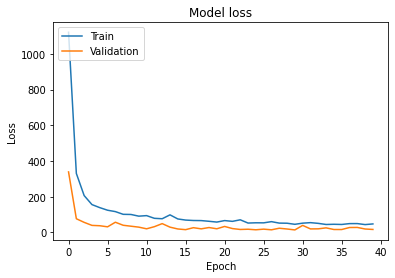

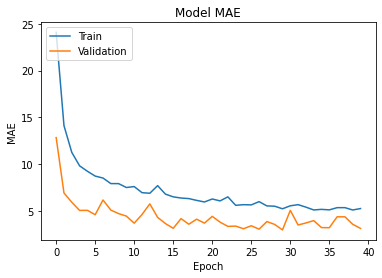

In [24]:
%matplotlib inline

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
predictions = model.predict(np.array(x_test))


2023-08-01 20:48:33.268431: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 265298880 exceeds 10% of free system memory.


In [86]:
import pandas as pd

# Create an empty list to store rows
rows = []

# Initialize index counter
index_counter = 0


# Loop through the values of i
for i in range(len(X_test_resized)):
    
    # Real values
    abc = np.array(y_test[i]).reshape(7,3) * img.GetSpacing()[0:3]
    theta = np.degrees(np.arccos(np.dot(abc[1]-abc[0], abc[2]-abc[1]) /
                                 (np.linalg.norm(abc[1]-abc[0]) * np.linalg.norm(abc[2]-abc[1]))))
    dist_ta = np.linalg.norm(np.array(y_test[i]).reshape(7,3)[3] * img.GetSpacing() - np.array(y_test[i]).reshape(7,3)[4] * img.GetSpacing())
    dist_oc = np.linalg.norm(np.array(y_test[i]).reshape(7,3)[5] * img.GetSpacing() - np.array(y_test[i]).reshape(7,3)[6] * img.GetSpacing())

    # Predicted values
    abc_pred = np.round(predictions[i]).reshape(7,3) * img.GetSpacing()[0:3]
    theta_pred = np.degrees(np.arccos(np.dot(abc_pred[1]-abc_pred[0], abc_pred[2]-abc_pred[1]) /
                                       (np.linalg.norm(abc_pred[1]-abc_pred[0]) * np.linalg.norm(abc_pred[2]-abc_pred[1]))))
    dist_ta_pred = np.linalg.norm(np.array(predictions[i]).reshape(7,3)[3] * img.GetSpacing() - np.array(predictions[i]).reshape(7,3)[4] * img.GetSpacing())
    dist_oc_pred = np.linalg.norm(np.array(predictions[i]).reshape(7,3)[5] * img.GetSpacing() - np.array(predictions[i]).reshape(7,3)[6] * img.GetSpacing())

    # Append values as a dictionary with the updated index
    rows.append({'Type': 'Real', 'Angle SP': round(theta, 2), 'Diameter TA': round(dist_ta, 2), 'Diameter OC': round(dist_oc, 2),'Index': index_counter})
    rows.append({'Type': 'Predicted', 'Angle SP': round(theta_pred, 2), 'Diameter TA': round(dist_ta_pred, 2), 'Diameter OC': round(dist_oc_pred, 2), 'Index': index_counter})
    index_counter += 1

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(rows)

# Group rows by the 'Index' column and join the rows
grouped_df = df.groupby('Index').agg(lambda x: ', '.join(map(str, x)))
grouped_df = grouped_df.iloc[:-1,:]
grouped_df

,Type,Angle SP,Diameter TA,Diameter OC
Index,,,,
0,"Real, Predicted","90.58, 90.67","120.52, 119.47","124.07, 116.99"
1,"Real, Predicted","88.04, 90.48","137.29, 124.52","110.75, 115.85"
2,"Real, Predicted","91.62, 91.22","127.55, 129.24","117.85, 118.51"
3,"Real, Predicted","88.05, 92.05","121.26, 122.83","143.64, 126.2"
4,"Real, Predicted","80.2, 95.39","116.0, 116.12","124.7, 114.59"
5,"Real, Predicted","81.91, 90.77","132.23, 116.9","121.83, 119.59"
6,"Real, Predicted","92.93, 96.61","120.65, 116.44","121.46, 115.09"
7,"Real, Predicted","86.53, 95.27","133.01, 120.58","124.53, 125.68"
8,"Real, Predicted","95.22, 93.53","116.41, 115.55","118.21, 111.86"


In [38]:
grouped_df.to_csv('/home/lcubero/landmarks_dataframes/initial_measures.csv', index = False)

Ejemplo para ver distancia de puntos

<IPython.core.display.Javascript object>


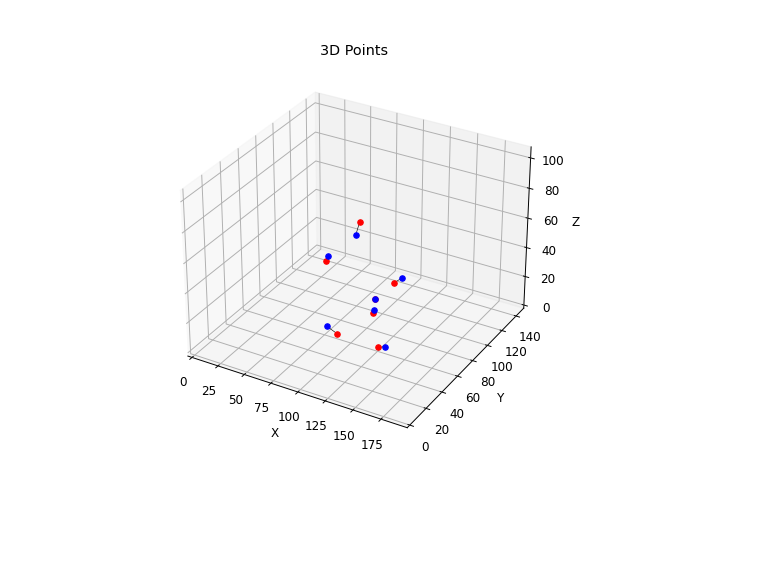

In [87]:
i = 12

predictions = model.predict(np.array(x_test))


pred = np.array(predictions[i]).reshape(7,3)
real =np.array(y_test[i]).reshape(7,3)
          
          

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))  # Adjust the figsize as desired

# Create a 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot all the points with their respective colors
for i in range(len(pred)):
    ax.scatter(pred[i, 0], pred[i, 1], pred[i, 2], color='red')

# reals
for i in range(len(real)):
    ax.scatter(real[i, 0], real[i, 1], real[i, 2], color='blue')

# Set labels and title for the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points')

# Set plot limits for x, y, and z axes
ax.set_xlim([0, x_test[0].shape[0]])  # Set limits for x-axis
ax.set_ylim([0, x_test[0].shape[1]])  # Set limits for y-axis
ax.set_zlim([0, x_test[0].shape[2]])  # Set limits for z-axis


ax.view_init(elev=30, azim=-60) # rotar el plot

for i in range(len(real)):
    ax.plot([pred[i, 0], real[i, 0]],
            [pred[i, 1], real[i, 1]],
            [pred[i, 2], real[i, 2]],
            color='black',
            linewidth=0.5)

# Show the plot
plt.show()

### Análisis de resultados

In [414]:
import pandas as pd
import numpy as np

# Crear una lista vacía para almacenar los valores
data = []

img = sitk.ReadImage(X_test_resized[0])

# Iterar sobre los índices de y_test
for i in range(len(y_test)):
    distances = np.linalg.norm(predictions[i].reshape(7,3)* img.GetSpacing() - np.array(y_test[i]).reshape(7,3)*img.GetSpacing(), axis=1)
#     distances = np.linalg.norm(predictions[i].reshape(7,3) - y_test[i].reshape(7,3), axis=1)
    data.append(['Patient_'+str(i)] + distances.tolist())

# Crear el DataFrame a partir de la lista de datos
df = pd.DataFrame(data, columns=["Iteración"] + ["l" + str(j) +'_error' for j in range(7)])
df.drop([0,10,15,21], inplace = True)

# Calcular la media y la varianza de cada columna
column_means = df.iloc[:, 1:].mean()
column_variances = df.iloc[:, 1:].var()

# Crear un nuevo DataFrame con la media y la varianza
mean_variance_df = pd.DataFrame({"Iteración": ["Mean", "Variance"],
                                 **{col: [column_means[col], column_variances[col]] for col in df.columns[1:]}})
# Combinar el DataFrame original con el DataFrame de media y varianza
df = pd.concat([df, mean_variance_df], ignore_index=True)

df

,Iteración,l0_error,l1_error,l2_error,l3_error,l4_error,l5_error,l6_error
0,Patient_1,11.190592,7.936260,13.877060,12.575962,6.378338,3.926873,9.153357
1,Patient_2,9.431877,7.119877,3.077602,14.127769,8.921545,3.846403,8.496862
2,Patient_3,8.738013,8.887586,4.565389,10.800785,7.718550,14.435627,10.484468
3,Patient_4,10.254212,3.960592,4.646333,7.778401,2.864532,5.832400,11.033163
4,Patient_5,17.222210,10.410565,14.387973,8.780383,12.776341,11.235686,8.845029
5,Patient_6,13.350134,6.741654,4.407093,7.703448,6.849991,7.639499,15.130665
6,Patient_7,14.764045,3.972321,12.708643,11.886919,10.839182,3.194542,12.628113
7,Patient_8,15.347768,4.700525,9.723715,7.802726,17.000115,2.202090,6.818957
8,Patient_9,9.401997,10.009400,9.372987,10.226014,13.148364,13.134540,11.322501
9,Patient_11,10.212709,19.472309,12.062869,10.197591,4.722318,13.131804,14.506852


In [415]:
df.to_csv('/home/lcubero/landmarks_dataframes/initial_predictions.csv', index = False)

<IPython.core.display.Javascript object>


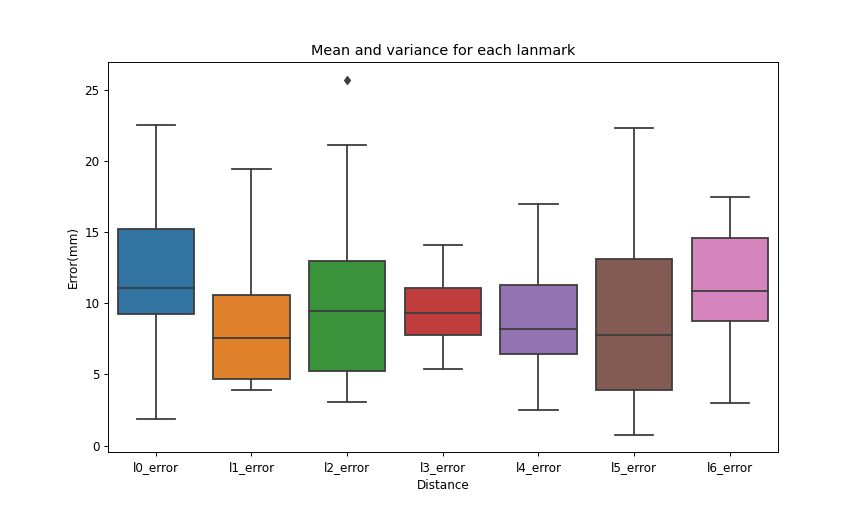

In [416]:
import seaborn as sns

# Crear el diagrama de caja
plt.figure(figsize=(10,6))
sns.boxplot(data=df)

plt.title('Mean and variance for each lanmark')
plt.xlabel('Distance')
plt.ylabel('Error(mm)')
plt.show()

## Subredes

Empezamos por ejemplo haciendo una subred para predecir el landmark 0, correspondiente al izq del ángulo subpúbico.
Si tiene un error aprox de 25 mm o lo que viene a ser 13 pixeles, entonces haremos una caja de 30x30x20, por lo que en la imagen de mayor resolución equivale a multiplicar por (3,3,2) para saber su posición original antes de hacer el resampling.

El tamaño entonces será de (90,90,40).


predictions[0].reshape(7,3)[0:3]

In [103]:
img_original = sitk.ReadImage(X_train[0])
print('Original size:', img_original.GetSize())
print('Original spacing before resizing:', img_original.GetSpacing())

Original size: (582, 444, 280)
Original spacing before resizing: (0.6249999999999999, 0.6249999999999999, 1.0)


Visualizamos un ejemplo

<IPython.core.display.Javascript object>


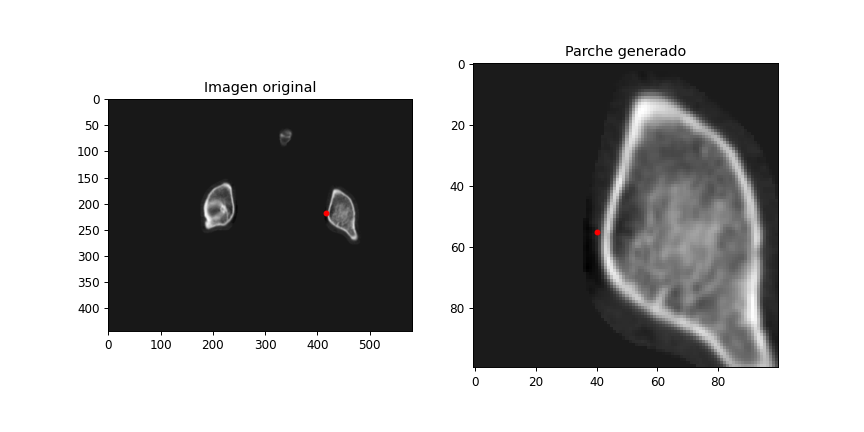

In [126]:
# Definir el tamaño del parche y el rango de desplazamiento
import random

patch_size = 100
shift_range = 40

i = 0
slide = 3

imagen = sitk.ReadImage(X_train[i])
img = sitk.GetArrayFromImage(imagen)

a = round(np.loadtxt(Y_train[i]).reshape(7,3)[slide][0])
b = round(np.loadtxt(Y_train[i]).reshape(7,3)[slide][1])
c = round(np.loadtxt(Y_train[i]).reshape(7,3)[slide][2]) #- (np.loadtxt(Y_train[i]).reshape(7,3)[slide][2]-20)


# Generar un desplazamiento aleatorio dentro del rango especificado
shift_a = random.randint(-shift_range, shift_range)
shift_b = random.randint(-shift_range, shift_range)
shift_c = random.randint(-3, 3)

# Calcular las coordenadas del parche
patch_a_start = a - patch_size // 2 + shift_a
patch_a_end = patch_a_start + patch_size

patch_b_start = b - patch_size // 2 + shift_b
patch_b_end = patch_b_start + patch_size

patch_c_start = c - patch_size // 2 + shift_c
patch_c_end = patch_c_start + patch_size



# Recortar el parche de la imagen
cropped_img = sitk.GetArrayFromImage(imagen[patch_a_start:patch_a_end, patch_b_start:patch_b_end, c])

# Visualizar la imagen y el parche
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img = sitk.GetArrayFromImage(imagen[:, :, c])

axes[0].imshow(img, cmap='gray')
axes[0].scatter(a,b, s=15, c='red', marker='o')
axes[0].set_title('Imagen original')

axes[1].imshow(cropped_img, cmap='gray')
axes[1].scatter(patch_size // 2 - shift_a, patch_size // 2 - shift_b, s=15, c='red', marker='o')
axes[1].set_title('Parche generado')

plt.show()

## Patch generation
Aunque a las imágenes les metamos un crop tenemos que tener en cuenta que debemos igualmente predecir su valor original, 230, 238, 210. Ya que al hacer el crop entonces siempre estarán en la posición 30,30,20.

In [30]:
import random
import numpy as np
import SimpleITK as sitk

def generate_patches(X_train, Y_train, slide, patch_size=100, patch_size_c=40, shift_range=10, shift_range_c=10):
    x_train_sub = []
    y_train_sub = []
    x_train_center = []

    for i in range(len(X_train)):
        IMG = sitk.ReadImage(X_train[i], sitk.sitkFloat32)
        Y = np.loadtxt(Y_train[i])

        a = round(np.array(Y).reshape(7, 3)[slide][0])
        b = round(np.array(Y).reshape(7, 3)[slide][1])
        c = round(np.array(Y).reshape(7, 3)[slide][2])

        shift_a = random.randint(-shift_range, shift_range)
        shift_b = random.randint(-shift_range, shift_range)
        shift_c = random.randint(-shift_range_c, shift_range_c)

        # Calcular las coordenadas del parche
        patch_a_start = a - patch_size // 2 + shift_a
        patch_a_end = patch_a_start + patch_size

        patch_b_start = b - patch_size // 2 + shift_b
        patch_b_end = patch_b_start + patch_size

        patch_c_start = c - patch_size_c // 2 + shift_c
        patch_c_end = patch_c_start + patch_size_c

        # Recortar el parche de la imagen
        cropped_img = IMG[patch_a_start:patch_a_end, patch_b_start:patch_b_end, patch_c_start:patch_c_end]
        l = [patch_size // 2 - shift_a, patch_size // 2 - shift_b, patch_size_c // 2 - shift_c]

        cropped_img.SetOrigin(IMG.GetOrigin())

        x_train_sub.append(cropped_img)
        y_train_sub.append(l)
        x_train_center.append((patch_a_end - patch_size, patch_b_end - patch_size, patch_c_end - patch_size))
    
    return x_train_sub, y_train_sub, x_train_center

In [31]:
slide = 6  # Your desired slide value
patch_size = 100  # Optional: You can modify the patch size if needed
patch_size_c = 40  # Optional: You can modify the patch size_c if needed
shift_range = 10  # Optional: You can modify the shift range if needed
shift_range_c = 10  # Optional: You can modify the shift range_c if needed

x_train_sub, y_train_sub, x_train_center = generate_patches(X_train, Y_train, slide, patch_size, patch_size_c, shift_range, shift_range_c)

In [33]:
import random
import numpy as np
import SimpleITK as sitk

def apply_rotation_and_scaling(x_train_sub, y_train_sub, min_rotation_degrees=-15, max_rotation_degrees=15,
                               min_scaling_factor=0.9, max_scaling_factor=1.1, probability=0.5):
    x_train_sub_aug = []
    y_train_sub_aug = []

    spacing = x_train_sub[0].GetSpacing()

    # Iterate over the images
    for a in range(len(x_train_sub)):
        # Load the labels and the images
        image1 = x_train_sub[a]
        landmark1 = y_train_sub[a]

        # Check the probability for applying rotation or scaling
        for i in range(10):

            # ============== RANDOM SCALING ================
            if random.random() < probability:
                # Generate a random scaling factor within the defined range
                scaling_factor = random.uniform(min_scaling_factor, max_scaling_factor)

                while scaling_factor == 1:
                    scaling_factor = random.uniform(min_scaling_factor, max_scaling_factor)

                # Create the augmentation transform for scaling
                scaling_transform = sitk.AffineTransform(3)

                # Set the scaling parameters
                scaling_params = (scaling_factor, scaling_factor, scaling_factor)
                scaling_transform.Scale(scaling_params)
                rotation_center = image1.TransformContinuousIndexToPhysicalPoint([image1.GetWidth() / 2,
                                                                                  image1.GetHeight() / 2,
                                                                                  image1.GetDepth() / 2])

                scaling_transform.SetCenter(rotation_center)

                # Apply the augmentation transform to the image
                augmented_image = sitk.Resample(image1, image1, scaling_transform, sitk.sitkLinear, 0.0)

                # Apply the augmentation transform to the landmarks
                transformada_inv_scale = scaling_transform.GetInverse()
                landmarks_aug = [transformada_inv_scale.TransformPoint(point) for point in
                                 np.array(landmark1).reshape(1, 3) * (-1, -1, 1) * np.array((spacing))]
                landmarks_aug = landmarks_aug / np.array(spacing) * (-1, -1, 1)

            else:
                landmarks_aug = landmark1
                augmented_image = image1

            # ============== RANDOM ROTATION ================
            rotation_angle_degrees = random.uniform(min_rotation_degrees, max_rotation_degrees)

            while rotation_angle_degrees == 0:
                rotation_angle_degrees = random.uniform(min_rotation_degrees, max_rotation_degrees)

            # Compute the rotation center
            rotation_center = augmented_image.TransformContinuousIndexToPhysicalPoint([augmented_image.GetWidth() / 2,
                                                                                       augmented_image.GetHeight() / 2,
                                                                                       augmented_image.GetDepth() / 2])

            # Convert the rotation angle to radians
            rotation_angle_radians = np.radians(rotation_angle_degrees)

            # Create the augmentation transform for rotation
            rotation_transform = sitk.Euler3DTransform(rotation_center, 0, 0, rotation_angle_radians)

            # Apply the augmentation transform to the image
            augmented_image = sitk.Resample(augmented_image, augmented_image, rotation_transform, sitk.sitkLinear, 0.0)

            # Apply the augmentation transform to the landmarks
            transformada_inv_rot = rotation_transform.GetInverse()
            landmarks_aug_RS = [transformada_inv_rot.TransformPoint(point) for point in
                                np.array(np.array(landmarks_aug).reshape(1, 3) * (-1, -1, 1)) * np.array((spacing))]
            valor = (np.array(landmarks_aug_RS) / np.array(spacing) * (-1, -1, 1))
            valor_px = (np.array([[round(value) for value in sublist] for sublist in valor]).reshape(-1))

            x_train_sub_aug.append(augmented_image)
            y_train_sub_aug.append(valor_px)

    return x_train_sub_aug, y_train_sub_aug

In [34]:
x_train_sub_aug, y_train_sub_aug = apply_rotation_and_scaling(x_train_sub, y_train_sub,
                                                              min_rotation_degrees=-15, max_rotation_degrees=15,
                                                              min_scaling_factor=0.9, max_scaling_factor=1.1,
                                                              probability=0.5)

In [35]:
x_train_sub_aug_list =[sitk.GetArrayFromImage(x_train_sub_aug[a]).transpose(2, 1, 0) for a in range(len(x_train_sub_aug))]
x_train_sub_list =[sitk.GetArrayFromImage(x_train_sub[a]).transpose(2, 1, 0) for a in range(len(x_train_sub))]


In [36]:
# Concatenate the original and augmented data + READ IMAGES AND LANDMARKS
x_train_sub_augmented = np.concatenate((x_train_sub_aug_list, x_train_sub_list), axis=0)
y_train_sub_augmented = np.concatenate((y_train_sub_aug, y_train_sub), axis=0)

In [39]:
def generate_validation_patches(X_val, Y_val, slide, patch_size=100, patch_size_c=40, shift_range=10, shift_range_c=10):
    x_val_sub = []
    y_val_sub = []

    for i in range(len(X_val)):
        a = round(np.loadtxt(Y_val[i]).reshape(7, 3)[slide][0])
        b = round(np.loadtxt(Y_val[i]).reshape(7, 3)[slide][1])
        c = round(np.loadtxt(Y_val[i]).reshape(7, 3)[slide][2])

        shift_a = random.randint(-shift_range, shift_range)
        shift_b = random.randint(-shift_range, shift_range)
        shift_c = random.randint(-shift_range_c, shift_range_c)

        # Calculate the coordinates of the patch
        patch_a_start = a - patch_size // 2 + shift_a
        patch_a_end = patch_a_start + patch_size

        patch_b_start = b - patch_size // 2 + shift_b
        patch_b_end = patch_b_start + patch_size

        patch_c_start = c - patch_size_c // 2 + shift_c
        patch_c_end = patch_c_start + patch_size_c

        # Recortar el parche de la imagen
        img = sitk.ReadImage(X_val[i], sitk.sitkFloat32)
        cropped_img = img[patch_a_start:patch_a_end, patch_b_start:patch_b_end, patch_c_start:patch_c_end]

        l = [patch_size // 2 - shift_a, patch_size // 2 - shift_b, patch_size_c // 2 - shift_c]

        cropped_img.SetOrigin(img.GetOrigin())
        x_val_sub.append(cropped_img)
        y_val_sub.append(l)

    return x_val_sub, y_val_sub

x_val_sub, y_val_sub = generate_validation_patches(X_val, Y_val, slide, patch_size, patch_size_c, shift_range, shift_range_c)

## En este caso el patch de las imagenes de test lo sacamos en base a las predicciones

In [43]:
def generate_test_patches(X_test, Y_test, predictions, slide, patch_size=100, patch_size_c=40):
    x_test_sub = []
    y_test_sub = []

    for i in range(len(X_test)):
        a = round(predictions[i].reshape(7, 3)[slide][0]) * 3  # para sacar el equivalente en la imagen original
        b = round(predictions[i].reshape(7, 3)[slide][1]) * 3
        c = round(predictions[i].reshape(7, 3)[slide][2]) * 2

        img = sitk.ReadImage(X_test[i], sitk.sitkFloat32)
        img_array = img[a - patch_size // 2:a + patch_size // 2, b - patch_size // 2:b + patch_size // 2,
                    c - patch_size_c // 2:c + patch_size_c // 2]

        l = [np.loadtxt(Y_test[i])[slide][0] - (a - patch_size // 2),
             np.loadtxt(Y_test[i])[slide][1] - (b - patch_size // 2),
             np.loadtxt(Y_test[i])[slide][2] - (c - patch_size_c // 2)]  # landmark que tiene que detectar

        img_array.SetOrigin(img.GetOrigin())
        x_test_sub.append(img_array)
        y_test_sub.append(l)

    return x_test_sub, y_test_sub

x_test_sub, y_test_sub = generate_test_patches(X_test, Y_test, predictions, slide, patch_size, patch_size_c)


## Entrenamiento de la primera subred

In [44]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

# Define the input shape
input_shape_ = (patch_size, patch_size, patch_size_c, 1)  # 70x60x40 images with a single channel (grayscale)
def create_model_2DBased_l1():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(64, (3,3,3), activation='relu', input_shape=input_shape_), # Asegúrate de que x, y, z sean las dimensiones correctas
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        # dropout 0.5
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        
        # dropout
        tf.keras.layers.Dense(3, activation='relu'),
#         tf.keras.layers.Dense(21)  # 3 neuronas para predecir las coordenadas x, y, z
    ])

#     opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(optimizer= 'adam' , loss='mse', metrics=['mae'])  # Usamos 'mse' para la pérdida y 'mae' como métrica adicional
    return model

In [45]:
x_val_sub_list =[sitk.GetArrayFromImage(x_val_sub[a]).transpose(2, 1, 0) for a in range(len(x_val_sub))]
x_test_sub_list =[sitk.GetArrayFromImage(x_test_sub[a]).transpose(2, 1, 0) for a in range(len(x_test_sub))]


## Landmark 0

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def train_model(model, x_train, y_train, x_val, y_val, epochs=100, batch_size=32, model_weights_file="./weights/SUBRED_L0_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"):
    # Define callbacks
    plateau = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.2, patience=5, min_lr=0.000001, verbose=1)
    earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_weights_file, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1)

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                        callbacks=[plateau, DisplayCallback(), earlystop, checkpoint], 
                        shuffle=True, validation_data=(x_val, y_val))

    return history

In [51]:
np.loadtxt(Y_test[i])[slide]

array([269.21105754, 152.60024846, 140.85341947])

In [69]:
import pandas as pd
import numpy as np

def evaluate_model(predictions, x_test_sub_list, y_test_sub, X_test, Y_test, slide, patch_size=100):
    resultados = []
    spacing = sitk.ReadImage(X_test[0]).GetSpacing()

    # Iterate through the loop and calculate the result for each iteration
    for i in range(len(predictions)):
        print(np.array(predictions[i]))
        resultado = np.linalg.norm(np.array(predictions[i]) * spacing - np.array(y_test_sub[i]) * spacing)
        resultados.append({'Distancia': resultado, 
                           'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                           'Predicted':  np.array(predictions[i])* spacing * (3,3,2),
                           'Predicted subred': np.array(predictions[i])* spacing * (3,3,0) - np.array((patch_size // 2, patch_size // 2, 0)) * spacing + (np.array(predictions_l0[i])) * spacing})

    # Create the DataFrame from the list of data
    df = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
    df.drop([0, 10, 15, 21], inplace=True)

    mean_distance = df['Distancia'].mean()
    variance_distance = df['Distancia'].var()

    return df, mean_distance, variance_distance

In [68]:
predictions_l0 = model_l0.predict(np.array(x_test_sub_list))
df0, mean_distance, variance_distance = evaluate_model(predictions_l0, x_test_sub_list, y_test_sub, X_test, Y_test, slide)


[44.925095 43.39252  19.886934]


IndexError: index 6 is out of bounds for axis 0 with size 3

<IPython.core.display.Javascript object>


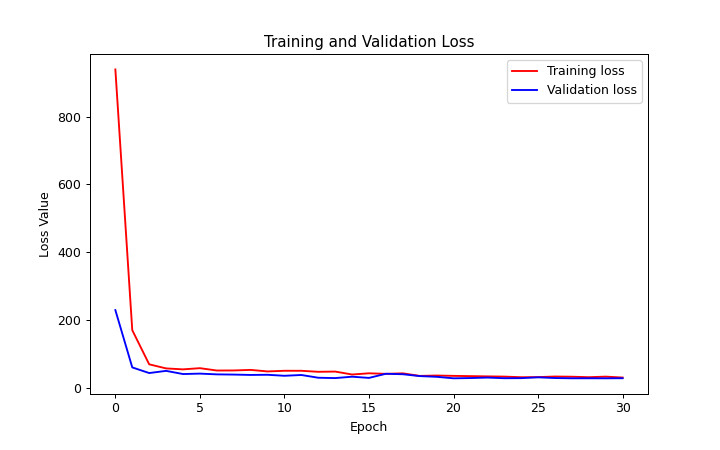

Restoring model weights from the end of the best epoch: 21.

Epoch 31: val_loss did not improve from 27.38125
17/17 [==============================] - 4s 247ms/step - loss: 29.6169 - mae: 4.3119 - val_loss: 27.6243 - val_mae: 4.3855 - lr: 4.0000e-05
Epoch 31: early stopping


ValueError: cannot reshape array of size 3 into shape (7,3)

In [48]:
# Model Creation
model_l0 = create_model_2DBased_l1()

# Model Training
history = train_model(model_l0, np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), np.array(x_val_sub_list), np.array(y_val_sub))

# Model Evaluation
predictions_l0 = model_l0.predict(np.array(x_test_sub_list))
df0, mean_distance, variance_distance = evaluate_model(predictions_l0, x_test_sub_list, y_test_sub, X_test, Y_test, slide)
print('Mean:', mean_distance)
print('Variance:', variance_distance)
print(df0)

<IPython.core.display.Javascript object>


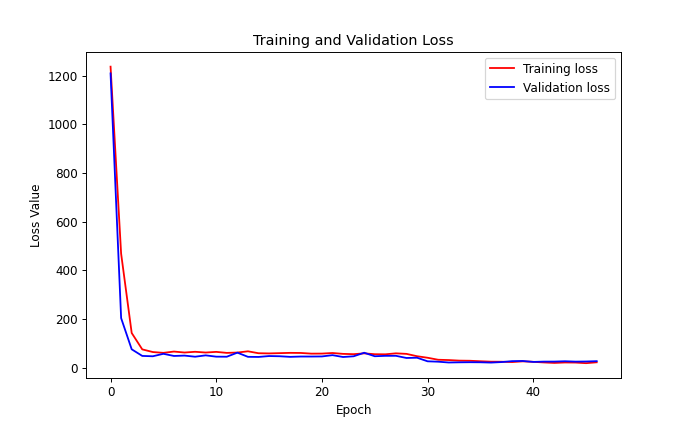


Epoch 47: val_loss did not improve from 20.64157
17/17 [==============================] - 4s 247ms/step - loss: 21.8314 - mae: 3.5827 - val_loss: 26.4982 - val_mae: 3.8220
Epoch 47: early stopping


In [257]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)


model_l0 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L0_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l0.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))   

In [259]:
# model_l0 = create_model_2DBased()
# model_l0.load_weights('./weights/SUBRED_L0_0602_resizedImg_weights.37-17.25.hdf5')

predictions_l0 = model_l0.predict(np.array(x_test_sub_list))

In [263]:
import pandas as pd # TABLA L0 (EL PRIMERO)
import numpy as np

# Crear una lista para almacenar los resultados
resultados = []
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l0)):
    resultado = np.linalg.norm(np.array(predictions_l0[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,0)-np.array((patch_size//2, patch_size//2, 0))*spacing + (np.array(predictions_l0[i]))*spacing})

# Create the DataFrame from the list of data
df0 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
# df0.drop([0,10,15], inplace = True)
df0.drop([0,10,15,21], inplace = True)

print('Mean:', df0['Distancia'].mean())
print('Variance:', df0['Distancia'].var())
df0

Mean: 8.359950832464405
Variance: 18.255777010194546


,Distancia,Real,Predicted,Predicted subred
1,8.745337,"[256.58921911597486, 99.92058443083792, 6.760590408347898]","[250.3240585327148, 106.26088857650754, 0.0]","[251.22190237045282, 106.58907175064084, 4.832157135009766]"
2,6.271159,"[254.9333172418185, 135.3435451859708, -0.0086223136759231]","[261.9893646240234, 141.5869045257568, 0.0]","[255.17609834671015, 140.40991544723508, 1.7250983715057373]"
3,3.903397,"[253.9825933584645, 115.75158452644621, 1.650717607224643]","[248.74108314514154, 110.71257591247556, 6.509254455566406]","[251.1705064773559, 113.56700181961057, 3.9592626094818115]"
4,5.268970,"[212.46236529052965, 120.50470930358391, 2.6064512103142317]","[206.53827667236322, 112.14669227600095, 2.1057815551757812]","[210.64523935317987, 116.53784990310666, 5.811380863189697]"
5,15.454959,"[226.75105497006572, 140.17970985291066, 12.826992386954224]","[209.80652332305903, 142.44469642639157, 10.679125785827637]","[212.80816555023188, 146.77005529403684, 15.202864646911621]"
6,11.785922,"[230.10150110862145, 109.95828543526768, 3.0661062378240995]","[217.57405757904047, 114.52141284942624, 2.404994249343872]","[223.352620601654, 119.64143753051755, 4.25189208984375]"
7,11.136710,"[240.15844089006566, 102.18954613646989, 14.583735788180386]","[228.30297946929926, 105.48643827438352, 6.410414218902588]","[231.8166017532348, 110.02185344696042, 11.802303314208984]"
8,12.196231,"[209.2116178994597, 119.99632172709808, 9.058870946529009]","[222.1823072433471, 113.38727474212644, 4.200993061065674]","[218.02444219589228, 111.72419071197507, 7.400317668914795]"
9,6.156682,"[211.1807594300176, 94.00936699214832, 4.074279782976481]","[202.26209163665766, 92.66013622283933, 1.4309850931167603]","[205.24974346160883, 94.65802431106565, 6.414072513580322]"
11,7.545865,"[243.21108496868567, 119.84708397115064, 0.4236212840415164]","[236.3389348983764, 126.28470897674558, 4.386602878570557]","[237.70772933959955, 125.39028644561765, 1.7719013690948486]"


In [264]:
df0.to_csv('/home/lcubero/landmarks_dataframes/l0_network_2.csv', index = False)

In [266]:
a = pd.read_csv('/home/lcubero/landmarks_dataframes/l0_network_2.csv')
print('Mean:', a['Distancia'].mean())
print('Variance:', a['Distancia'].var())

a

Mean: 8.359950832464405
Variance: 18.255777010194542


,Distancia,Real,Predicted,Predicted subred
0,8.745337,[256.58921912 99.92058443 6.76059041],[250.32405853 106.26088858 0. ],[251.22190237 106.58907175 4.83215714]
1,6.271159,[ 2.54933317e+02 1.35343545e+02 -8.62231368e-03],[261.98936462 141.58690453 0. ],[255.17609835 140.40991545 1.72509837]
2,3.903397,[253.98259336 115.75158453 1.65071761],[248.74108315 110.71257591 6.50925446],[251.17050648 113.56700182 3.95926261]
3,5.268970,[212.46236529 120.5047093 2.60645121],[206.53827667 112.14669228 2.10578156],[210.64523935 116.5378499 5.81138086]
4,15.454959,[226.75105497 140.17970985 12.82699239],[209.80652332 142.44469643 10.67912579],[212.80816555 146.77005529 15.20286465]
5,11.785922,[230.10150111 109.95828544 3.06610624],[217.57405758 114.52141285 2.40499425],[223.3526206 119.64143753 4.25189209]
6,11.136710,[240.15844089 102.18954614 14.58373579],[228.30297947 105.48643827 6.41041422],[231.81660175 110.02185345 11.80230331]
7,12.196231,[209.2116179 119.99632173 9.05887095],[222.18230724 113.38727474 4.20099306],[218.0244422 111.72419071 7.40031767]
8,6.156682,[211.18075943 94.00936699 4.07427978],[202.26209164 92.66013622 1.43098509],[205.24974346 94.65802431 6.41407251]
9,7.545865,[243.21108497 119.84708397 0.42362128],[236.3389349 126.28470898 4.38660288],[237.70772934 125.39028645 1.77190137]


## Landmark 1

<IPython.core.display.Javascript object>


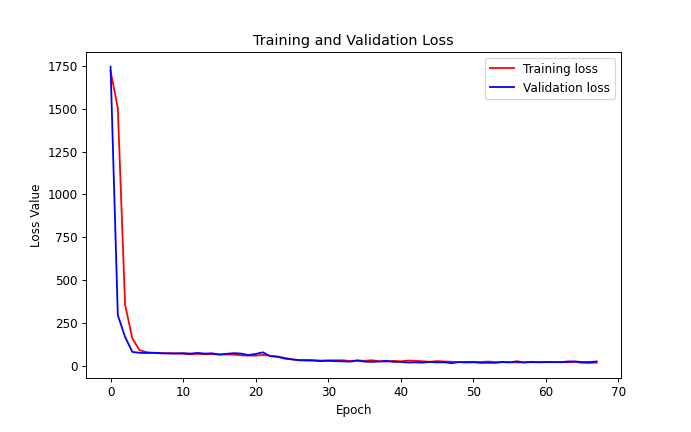


Epoch 68: val_loss did not improve from 17.39351
17/17 [==============================] - 6s 373ms/step - loss: 20.9519 - mae: 3.5422 - val_loss: 27.0815 - val_mae: 4.2093
Epoch 68: early stopping


In [292]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)


model_l1 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L1_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l1.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))

In [293]:
# model_l1.load_weights('./weights/SUBRED_L1_BUENO_0602_resizedImg_weights.33-11.98.hdf5')

predictions_l1 = model_l1.predict(np.array(x_test_sub_list))

In [294]:
import pandas as pd # TABLA L2 (EL SEGUNDO)
import numpy as np

# Crear una lista para almacenar los resultados
resultados = []


# Crear una lista para almacenar los resultados
resultados = []
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l1)):
    resultado = np.linalg.norm(np.array(predictions_l1[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,0)-np.array((patch_size//2, patch_size//2, 0))*spacing + (np.array(predictions_l1[i]))*spacing})

# Create the DataFrame from the list of data
df1 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
df1.drop([0,10,15,21], inplace = True)

print('Mean:', df1['Distancia'].mean())
print('Variance:', df1['Distancia'].var())

df1

Mean: 4.791901277441484
Variance: 6.926962942675106


,Distancia,Real,Predicted,Predicted subred
1,4.476791,"[211.4161327111744, 137.2967746163848, 21.70144734194165]","[209.97927188873285, 144.10353183746335, 17.90055274963379]","[211.2007093429565, 140.4479646682739, 18.822357177734375]"
2,3.652529,"[218.59197050109583, 178.63584254925203, 15.015811775984721]","[219.28331851959223, 184.7245073318481, 18.6367244720459]","[218.75435590744013, 180.9216666221618, 16.783239364624023]"
3,4.042595,"[210.3337133535817, 150.758733269122, 20.359946122849642]","[209.11894798278803, 143.7750148773193, 25.731582641601562]","[210.2678728103637, 146.51495933532712, 18.81049156188965]"
4,2.188354,"[169.98709025085677, 145.47164350768549, 18.16031473570486]","[170.91190338134763, 142.94713497161862, 21.076282501220703]","[172.41049051284787, 146.38215303421018, 18.06254005432129]"
5,5.033847,"[174.89509671826954, 182.3965677630669, 38.935653175156766]","[174.01283740997312, 176.82386398315427, 30.193599700927734]","[173.8687419891357, 180.43463706970212, 34.638187408447266]"
6,3.712880,"[187.703912723024, 152.60280605290308, 21.126043602829043]","[182.89070606231684, 148.03995609283444, 22.307178497314453]","[185.36870479583735, 150.57960987091062, 18.324129104614258]"
7,6.094486,"[189.6596185601089, 142.62591679769918, 30.68804567082712]","[188.72636318206781, 139.81970787048337, 28.03238296508789]","[190.3722739219665, 140.26085853576657, 24.955963134765625]"
8,1.114071,"[182.06931634001145, 141.5552664292465, 23.43814340746651]","[185.38963794708246, 144.83001708984372, 22.849729537963867]","[182.02776908874506, 141.16492748260495, 22.73888397216797]"
9,5.459252,"[166.0144824982549, 117.44166565242664, 23.42224120875773]","[167.65684604644773, 126.95354461669919, 20.742900848388672]","[166.79341077804563, 122.16723918914792, 24.83968162536621]"
11,11.264190,"[198.27187026226477, 149.96808616841628, 14.205084907088391]","[200.02703189849848, 166.11349582672116, 24.933246612548828]","[198.57131958007807, 160.14245271682736, 16.751325607299805]"


In [295]:
df1.to_csv('/home/lcubero/landmarks_dataframes/l1_network_2.csv', index = False)

## Landmark 2

<IPython.core.display.Javascript object>


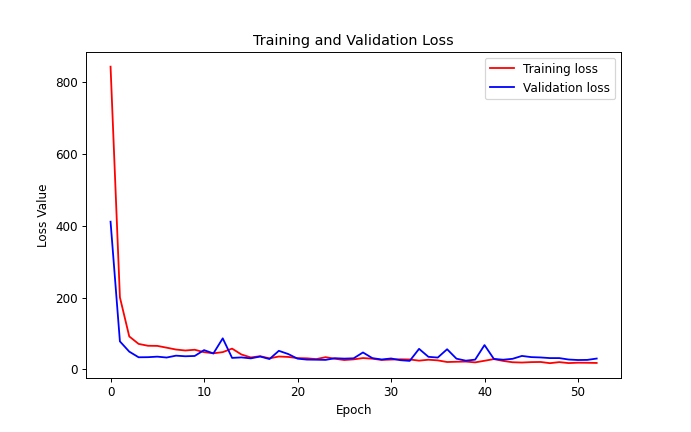


Epoch 53: val_loss did not improve from 23.59855
17/17 [==============================] - 4s 247ms/step - loss: 17.8923 - mae: 3.2823 - val_loss: 30.1612 - val_mae: 4.2112
Epoch 53: early stopping


In [322]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)


model_l2 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L2_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l2.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))

In [323]:
predictions_l2 = model_l2.predict(np.array(x_test_sub_list))

In [324]:
import pandas as pd # TABLA L2 (EL SEGUNDO)
import numpy as np

# Crear una lista para almacenar los resultados
resultados = []


# Crear una lista para almacenar los resultados
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l2)):
    resultado = np.linalg.norm(np.array(predictions_l2[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,0)-np.array((patch_size//2, patch_size//2, 0))*spacing + (np.array(predictions_l2[i]))*spacing})

# Create the DataFrame from the list of data
df2 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
df2.drop([0,10,15,21], inplace = True)

print('Mean:', df2['Distancia'].mean())
print('Variance:', df2['Distancia'].var())

df2

Mean: 7.016503589562636
Variance: 9.938359971118725


,Distancia,Real,Predicted,Predicted subred
1,7.562195,"[170.45166494727366, 96.51917146697073, 8.006134841941648]","[169.36945438385007, 107.81179189682004, 0.0]","[172.80573368072507, 104.19473886489865, 5.045253753662109]"
2,1.563988,"[178.69457441344935, 147.95188258831456, 1.1897676933431198]","[175.88942527770993, 147.4562358856201, 0.0]","[177.7747559547424, 147.15162038803098, 2.6444196701049805]"
3,7.294302,"[169.73522549957778, 111.35876226082121, 5.613730302537143]","[171.52118682861325, 107.28843212127683, 6.6859965324401855]","[169.86907005310056, 105.55591106414792, 9.353181838989258]"
4,3.243056,"[133.25185122192613, 112.09702497741205, 1.0502073138298569]","[136.7800712585449, 109.26944017410275, 0.0]","[135.29199361801145, 112.44457960128781, 3.4852311611175537]"
5,9.704076,"[125.2903680156145, 148.5955423724419, 19.523078752453863]","[137.29821681976316, 145.9023284912109, 12.069315910339355]","[134.83841896057126, 151.42685174942014, 18.62833023071289]"
6,9.696835,"[145.12906450443182, 113.80227661498104, 2.066106238770997]","[147.80616760253903, 116.62044525146482, 0.0]","[151.21091365814206, 121.45492315292356, 1.8945808410644531]"
7,9.498930,"[140.54994675546885, 96.89534286880335, 9.199391993345936]","[149.8109149932861, 103.88665437698361, 4.010422229766846]","[147.7210474014282, 103.66110086441037, 9.10947322845459]"
8,8.648921,"[156.65525193266282, 112.23193268901214, 9.658358251216509]","[150.05167007446286, 111.45755767822263, 2.566211223602295]","[149.3507623672485, 108.52822065353391, 9.322193145751953]"
9,5.042055,"[124.75038528450976, 89.5423889190282, 6.021484372820231]","[129.07007217407224, 95.28545379638669, 0.0]","[127.50399589538571, 92.69028663635251, 7.997691631317139]"
11,7.219775,"[152.61677039349036, 125.27190391743969, 3.0828620066977663]","[160.271201133728, 134.59765434265134, 3.221243381500244]","[159.15700912475583, 129.35746908187863, 2.7241950035095215]"


In [325]:
df2.to_csv('/home/lcubero/landmarks_dataframes/l2_network_2.csv', index = False)

In [327]:
l2_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l2_network_2.csv')
print('Mean:', l2_results['Distancia'].mean())
print('Variance:', l2_results['Distancia'].var())

Mean: 7.016503589562637
Variance: 9.938359971118725


## Landmark 3

<IPython.core.display.Javascript object>


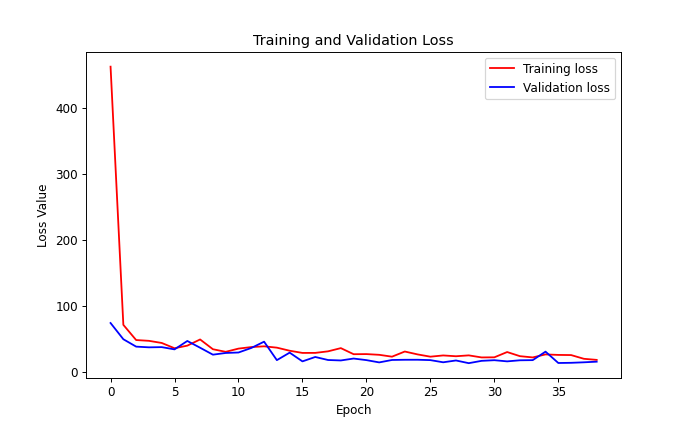


Epoch 39: val_loss did not improve from 12.97325
17/17 [==============================] - 4s 247ms/step - loss: 17.9615 - mae: 3.3598 - val_loss: 15.2508 - val_mae: 3.2544
Epoch 39: early stopping


In [339]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)


model_l3 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L3_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l3.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))

In [340]:
predictions_l3 = model_l3.predict(np.array(x_test_sub_list))

In [341]:
import pandas as pd # TABLA L2 (EL SEGUNDO)
import numpy as np

# Crear una lista para almacenar los resultados
resultados = []


# Crear una lista para almacenar los resultados
resultados = []
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l3)):
    resultado = np.linalg.norm(np.array(predictions_l3[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,2)-np.array((patch_size//2, patch_size//2, patch_size_c//2))*spacing + (np.array(predictions_l3[i]))*spacing})

# Create the DataFrame from the list of data
df3 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
df3.drop([0,10,15,21], inplace = True)

print('Mean:', df3['Distancia'].mean())
print('Variance:', df3['Distancia'].var())

df3

Mean: 7.309583861392968
Variance: 7.846975525710748


,Distancia,Real,Predicted,Predicted subred
1,11.162595,"[279.7473154294514, 127.11846040740042, 85.90860066225414]","[270.90087890624994, 118.76342296600339, 89.0514907836914]","[276.2461066246032, 118.36240768432614, 80.84074878692627]"
2,8.250189,"[283.7468891717501, 151.59752772991612, 79.89399514085288]","[283.8813972473144, 153.81005287170407, 93.85216522216797]","[286.7420053482055, 151.87731027603147, 87.68375873565674]"
3,9.354931,"[273.8109984916477, 130.3654554140049, 97.59984893587382]","[269.23130035400385, 120.63859462738034, 98.62511444091797]","[271.956193447113, 121.93186998367307, 100.23261260986328]"
4,5.861769,"[229.48001389848534, 127.72620691340927, 82.99362772398611]","[228.8067483901977, 120.5567407608032, 85.94357299804688]","[231.94447040557856, 124.31668519973752, 86.51938438415527]"
5,5.760828,"[238.53792246500205, 150.1060664157724, 100.62292360259372]","[230.67983150482172, 149.80572223663327, 96.7138442993164]","[236.42963171005243, 153.1880164146423, 97.12080192565918]"
6,3.494006,"[247.17994985664683, 122.05319194044445, 83.92528443405598]","[240.04986763000483, 120.38945674896237, 86.3048324584961]","[245.46468734741205, 124.47389125823972, 86.45866966247559]"
7,6.548211,"[253.5816580800829, 117.81034907067954, 104.9875160778186]","[247.14760780334467, 114.35516595840451, 95.59503936767578]","[250.85069894790644, 115.77752113342282, 98.82327270507812]"
8,6.143307,"[241.50659699491862, 118.38212494975436, 80.99417368090401]","[243.42910766601557, 121.19441986083982, 88.02013397216797]","[241.8752765655517, 117.2438025474548, 87.10160446166992]"
9,7.276999,"[227.37413406380665, 108.64176845851794, 94.60351562282023]","[224.71509933471674, 103.04670095443723, 86.46329498291016]","[226.64963722228998, 102.67621278762815, 90.81220436096191]"
11,5.250980,"[263.39865309405667, 140.10266836443967, 93.99008856919765]","[255.7751083374023, 133.38074684143064, 93.16123962402344]","[262.3532652854919, 136.16887331008908, 90.56167030334473]"


In [342]:
df3.to_csv('/home/lcubero/landmarks_dataframes/l3_network_2.csv', index = False)

## Landmark 4

<IPython.core.display.Javascript object>


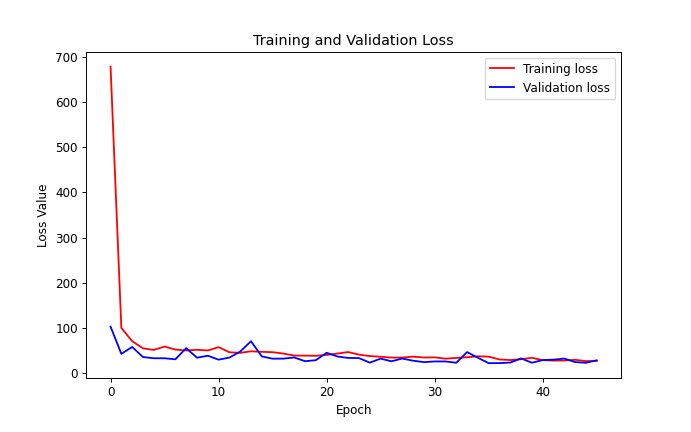


Epoch 46: val_loss did not improve from 22.56468
17/17 [==============================] - 4s 247ms/step - loss: 27.5084 - mae: 4.1356 - val_loss: 28.9133 - val_mae: 4.3048
Epoch 46: early stopping


In [354]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)


model_l4 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L4_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l4.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))

In [355]:
predictions_l4 = model_l4.predict(np.array(x_test_sub_list))

In [356]:
import pandas as pd # TABLA L2 (EL SEGUNDO)
import numpy as np

# Crear una lista para almacenar los resultados
resultados = []


# Crear una lista para almacenar los resultados
resultados = []
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l4)):
    resultado = np.linalg.norm(np.array(predictions_l4[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,2)-np.array((patch_size//2, patch_size//2, patch_size_c//2))*spacing + (np.array(predictions_l4[i]))*spacing})

# Create the DataFrame from the list of data
df4 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
df4.drop([0,10,15,21], inplace = True)

print('Mean:', df4['Distancia'].mean())
print('Variance:', df4['Distancia'].var())

df4

Mean: 7.15906802899999
Variance: 8.21045872956957


,Distancia,Real,Predicted,Predicted subred
1,7.606808,"[142.48059942603342, 127.67461275115042, 88.2706001739729]","[146.44464969635007, 122.67618656158444, 88.50128173828125]","[140.89297294616696, 121.47929191589353, 86.37690734863281]"
2,7.689232,"[158.3477764703341, 170.71251796429112, 93.28131661302085]","[154.94616508483884, 162.66177177429196, 95.05072784423828]","[156.03133201599118, 163.23045730590817, 95.01132011413574]"
3,7.461608,"[152.92595963154403, 120.82189971452306, 97.59984893587382]","[146.47074222564694, 116.59426689147946, 97.73955535888672]","[148.67787599563596, 115.60882806777951, 99.53512191772461]"
4,3.705670,"[113.8995410412621, 117.88373762389642, 83.90485208922048]","[112.7823185920715, 115.77328920364377, 85.48076629638672]","[111.86863899230954, 114.83165025711057, 82.06333541870117]"
5,10.786105,"[106.49191849277716, 151.3802010617272, 107.62292360259372]","[113.81353855133054, 152.70213603973386, 97.22679138183594]","[109.56738948822019, 152.47091531753537, 96.69869041442871]"
6,7.400666,"[126.60001600879677, 119.22077738697146, 80.92528443689667]","[123.63574504852292, 122.61135578155515, 86.0759048461914]","[128.05236577987668, 123.40728759765622, 87.35823631286621]"
7,7.911348,"[120.91387558240473, 108.309302054328, 103.3084160411975]","[126.58033847808835, 112.46149778366086, 95.04674530029297]","[121.4397859573364, 111.10730648040769, 95.11264991760254]"
8,11.907072,"[126.16516633085611, 102.55094819194187, 80.99417368090401]","[127.9177379608154, 118.23519229888913, 87.30266571044922]","[125.49851894378659, 114.20719146728513, 82.9970588684082]"
9,12.955374,"[109.09690856942187, 108.2595691711034, 98.69445800563273]","[108.14609527587888, 105.10285377502439, 85.97309112548828]","[108.9306569099426, 104.26526784896848, 86.3848991394043]"
11,3.896308,"[139.94138719299653, 148.39457428316757, 93.99008856919765]","[137.6195955276489, 144.40212249755857, 93.00688934326172]","[141.4303135871887, 145.47496318817136, 95.43499946594238]"


In [357]:
df4.to_csv('/home/lcubero/landmarks_dataframes/l4_network_2.csv', index = False)

## Landmark 5

<IPython.core.display.Javascript object>


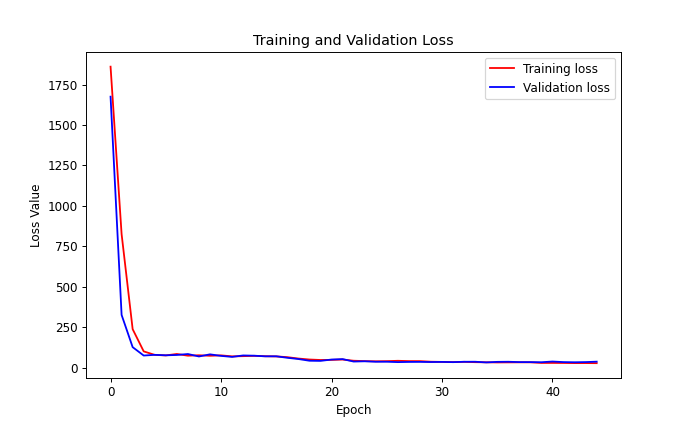


Epoch 45: val_loss did not improve from 33.69693
17/17 [==============================] - 6s 374ms/step - loss: 29.0388 - mae: 4.2491 - val_loss: 38.3243 - val_mae: 4.7579
Epoch 45: early stopping


In [388]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)

model_l5 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L5_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l5.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))

In [389]:
predictions_l5 = model_l5.predict(np.array(x_test_sub_list))

In [391]:
import pandas as pd # TABLA L5 (EL SEXTO)
import numpy as np

# Crear una lista para almacenar los resultados
resultados = []


# Crear una lista para almacenar los resultados
resultados = []
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l5)):
    resultado = np.linalg.norm(np.array(predictions_l5[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,2)-np.array((patch_size//2, patch_size//2, patch_size_c//2))*spacing + (np.array(predictions_l5[i]))*spacing})

# Create the DataFrame from the list of data
df5 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
df5.drop([0,10,15,21], inplace = True)

print('Mean:', df5['Distancia'].mean())
print('Variance:', df5['Distancia'].var())

df5

Mean: 5.445387904205628
Variance: 8.085411274172493


,Distancia,Real,Predicted,Predicted subred
1,2.832178,"[209.48518230796088, 147.35745882048636, 34.099701736472895]","[208.4088277816772, 151.1299896240234, 34.14655685424805]","[208.9197945594787, 149.27093267440793, 37.76404571533203]"
2,1.928735,"[220.77901464477262, 189.37671016399815, 33.919187401595075]","[219.95863437652582, 188.64744186401362, 37.60629653930664]","[221.43928527832026, 188.70108127593988, 39.59897232055664]"
3,11.740737,"[205.57791882843523, 163.1661162889658, 38.72523136297861]","[209.6099138259887, 149.79025840759275, 42.36553955078125]","[208.30449104309076, 152.23540544509885, 47.45866775512695]"
4,3.579302,"[169.28114428222887, 155.1881184459546, 33.13870544419338]","[169.132604598999, 149.92824554443357, 35.64421081542969]","[170.51333665847775, 153.050479888916, 41.57965087890625]"
5,7.194050,"[168.47154334173817, 189.6796793353326, 53.16999150382829]","[175.16784667968747, 183.67126464843744, 46.42814254760742]","[175.497031211853, 186.0204911231994, 69.29998016357422]"
6,4.779891,"[182.77377698409578, 159.94708517120395, 32.6846624796043]","[181.24527454376215, 154.10322189331052, 37.345184326171875]","[180.30167341232294, 156.04765415191648, 41.199440002441406]"
7,3.328340,"[184.63963603377715, 146.87210756345684, 44.89878150991735]","[185.58607578277582, 146.9683742523193, 41.853118896484375]","[186.44770145416254, 149.3889760971069, 54.64669418334961]"
8,5.141797,"[182.0405935769499, 151.39341341140985, 38.32750701423738]","[184.03148174285883, 150.50568580627439, 37.97283172607422]","[182.44072198867792, 147.45492458343503, 43.717063903808594]"
9,6.217085,"[168.25691096395315, 132.54918129818765, 46.431393407123046]","[165.2463626861572, 134.4644451141357, 33.80156707763672]","[164.74342584609983, 130.901985168457, 45.40803146362305]"
11,4.418506,"[200.26977790081457, 162.89037817009338, 30.702102703473244]","[200.85338115692133, 170.83788871765134, 41.130455017089844]","[201.85881614685053, 165.16933202743527, 38.17152214050293]"


In [408]:
df5.to_csv('/home/lcubero/landmarks_dataframes/l5_network_2.csv', index = False)

## Landmark 6

<IPython.core.display.Javascript object>


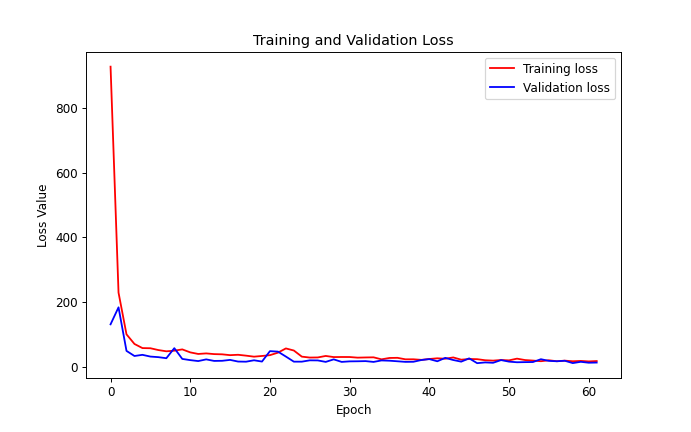


Epoch 62: val_loss did not improve from 11.11142
17/17 [==============================] - 4s 249ms/step - loss: 17.6721 - mae: 3.2573 - val_loss: 13.0183 - val_mae: 2.8779
Epoch 62: early stopping


In [403]:
plateau = ReduceLROnPlateau(monitor='val_loss',mode = "min", factor=0.2, patience=5, min_lr=0.000001,verbose = 1)


model_l6 = create_model_2DBased_l1()

earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights = True)

fname = "./weights/SUBRED_L6_0602_resizedImg_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(fname, monitor='val_loss', mode="min", save_best_only=True, save_weights_only=True, verbose=1) 


history = model_l6.fit(np.array(x_train_sub_augmented), np.array(y_train_sub_augmented), epochs=100, batch_size=32, 
                       callbacks=[earlystop, DisplayCallback(), checkpoint], shuffle = True, validation_data=(np.array(x_val_sub_list), np.array(y_val_sub)))

In [404]:
predictions_l6 = model_l6.predict(np.array(x_test_sub_list))

In [405]:
# Crear una lista para almacenar los resultados
resultados = []

# Crear una lista para almacenar los resultados
resultados = []
spacing = sitk.ReadImage(X_train[0]).GetSpacing()

# Iterate through the loop and calculate the result for each iteration
for i in range(len(predictions_l6)):
    resultado = np.linalg.norm(np.array(predictions_l6[i]) * spacing - np.array(y_test_sub[i]) * spacing)
    resultados.append({'Distancia': resultado, 
                       'Real': np.loadtxt(Y_test[i])[slide] * spacing,
                       'Predicted':  predictions[i].reshape(7,3)[slide]*spacing*(3,3,2),
                       'Predicted subred': predictions[i].reshape(7,3)[slide]*spacing*(3,3,2)-np.array((patch_size//2, patch_size//2, patch_size_c//2))*spacing + (np.array(predictions_l6[i]))*spacing})

# Create the DataFrame from the list of data
df6 = pd.DataFrame(resultados, columns=["Distancia", "Real", "Predicted", "Predicted subred"])
df6.drop([0,10,15,21], inplace = True)


print('Mean:', df6['Distancia'].mean())
print('Variance:', df6['Distancia'].var())

df6

Mean: 6.914979362377497
Variance: 16.318268919499317


,Distancia,Real,Predicted,Predicted subred
1,4.179961,"[210.77931156268184, 130.07088261746478, 143.4788045703967]","[206.36511325836176, 122.61102676391599, 146.41407775878906]","[209.30095911025995, 127.67826080322263, 141.62473392486572]"
2,3.977631,"[221.4409800149508, 160.67885707561925, 148.22608742600914]","[219.89706516265863, 152.65251159667966, 150.51405334472656]","[220.16657829284662, 158.01327705383298, 149.6000099182129]"
3,3.020147,"[208.59058874935653, 119.77717351570404, 175.61604963847464]","[207.36383914947504, 122.04264163970944, 165.45785522460938]","[209.09323215484613, 118.70825529098508, 172.62543487548828]"
4,7.613726,"[169.89253725708238, 100.39890486022453, 145.15286844664234]","[169.52623844146726, 111.31269693374631, 143.5336456298828]","[170.70589303970334, 107.04548597335813, 149.42562294006348]"
5,5.370593,"[173.07701209173817, 143.29542007607333, 165.714744590248]","[172.05821514129636, 139.82025146484372, 157.64744567871094]","[173.0489087104797, 140.86428642272946, 160.26052284240723]"
6,8.859309,"[189.91681621062776, 105.55426219536811, 141.0374845187349]","[181.15157604217524, 116.76049947738645, 146.2051239013672]","[186.36664628982538, 113.15271615982053, 145.74347114562988]"
7,9.983399,"[184.63963603377715, 122.67920632888892, 167.05310249757167]","[186.621823310852, 111.14685058593747, 162.32032775878906]","[185.15895605087275, 114.48279857635495, 162.71432876586914]"
8,4.968390,"[182.0405935769499, 112.92300842698619, 150.1094384784118]","[183.9154958724975, 116.29301548004148, 144.47032165527344]","[183.94087791442865, 110.48606634140012, 146.639554977417]"
9,7.407184,"[168.25691096395315, 95.37515528786928, 140.8534194733316]","[165.915412902832, 104.07279968261716, 147.72637939453125]","[169.16584968566892, 101.3824105262756, 143.18357753753662]"
11,12.283011,"[200.26977790081457, 145.78790467186016, 159.8257776151341]","[197.65929222106928, 133.2012605667114, 153.08328247070312]","[197.46088981628412, 137.34619140624997, 150.82169151306152]"


In [406]:
df6.to_csv('/home/lcubero/landmarks_dataframes/l6_network_2.csv', index = False)

## Results

In [8]:
l0_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l0_network_2.csv')
l1_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l1_network_2.csv')
l2_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l2_network_2.csv')
l3_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l3_network_2.csv')
l4_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l4_network_2.csv')
l5_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l5_network_2.csv')
l6_results = pd.read_csv('/home/lcubero/landmarks_dataframes/l6_network_2.csv')


results_matrix = [l0_results, l1_results, l2_results, l3_results, l4_results, l5_results, l6_results]
distances = []

i=0
for results in results_matrix:
    distances.append(results[results.columns[0]])
    i+=1
    
# Create the DataFrame from the list of distances
df_sub = pd.DataFrame(distances).transpose()
column_names = ['L' + str(i) for i in range(len(distances))]
df_sub.columns = column_names

# Add the 'Iteración' column

# Calculate the mean and variance
mean_values = df_sub.mean()
variance_values = df_sub.var()

# Add the 'Mean' row
df_sub.loc['Mean'] = mean_values

# Add the 'Variance' row
df_sub.loc['Variance'] = variance_values
df_sub.loc['Median'] = df_sub.median()


df_sub.rename(index={0: "Patient_0", 1: "Patient_1", 2: "Patient_2", 3: "Patient_3", 4: "Patient_4", 5: "Patient_5", 6: "Patient_6",
                    7: "Patient_7", 8: "Patient_8", 9: "Patient_9", 10: "Patient_10", 11: "Patient_11", 12: 'Patient_12', 13: 'Patient_13',
                    14: "Patient_14", 15: 'Patient_15', 16: 'Patient_16', 17: "Patient_17", 18: 'Patient_18', 19: 'Patient_19'}, inplace = True)

df_sub

,L0,L1,L2,L3,L4,L5,L6
Patient_0,8.745337,4.476791,7.562195,11.162595,7.606808,2.832178,4.179961
Patient_1,6.271159,3.652529,1.563988,8.250189,7.689232,1.928735,3.977631
Patient_2,3.903397,4.042595,7.294302,9.354931,7.461608,11.740737,3.020147
Patient_3,5.268970,2.188354,3.243056,5.861769,3.705670,3.579302,7.613726
Patient_4,15.454959,5.033847,9.704076,5.760828,10.786105,7.194050,5.370593
Patient_5,11.785922,3.712880,9.696835,3.494006,7.400666,4.779891,8.859309
Patient_6,11.136710,6.094486,9.498930,6.548211,7.911348,3.328340,9.983399
Patient_7,12.196231,1.114071,8.648921,6.143307,11.907072,5.141797,4.968390
Patient_8,6.156682,5.459252,5.042055,7.276999,12.955374,6.217085,7.407184
Patient_9,7.545865,11.264190,7.219775,5.250980,3.896308,4.418506,12.283011


/home/lcubero/miniconda3/envs/tf_env_copy/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<IPython.core.display.Javascript object>


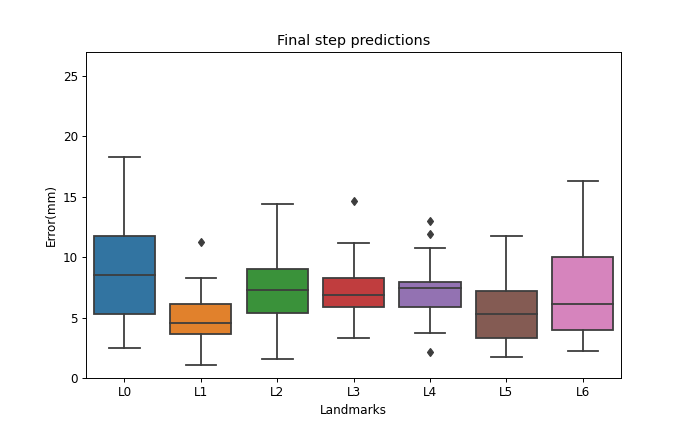

In [9]:
import seaborn as sns

# Crear el diagrama de caja
plt.figure(figsize=(8,5))
df_sub.drop(['Mean', 'Variance'])
sns.boxplot(data=df_sub)
plt.ylim(0, 27)

plt.title('Final step predictions')
plt.xlabel('Landmarks')
plt.ylabel('Error(mm)')
plt.show()

In [9]:
print(df_sub.loc['Mean'].mean())
print(df_sub.loc['Variance'].mean())
print(df_sub.loc['Median'].mean())

6.713910693777801
10.797459196134357
6.585895295549286


## First stage results

In [10]:
boxplot_1 = pd.read_csv('/home/lcubero/landmarks_dataframes/initial_predictions.csv')
boxplot_1.columns = ['Patient', 'L0','L1','L2','L3','L4','L5','L6']
boxplot_1.drop(columns='Patient', inplace = True)
boxplot_1.loc[20] = boxplot_1.median()
display(boxplot_1)


,L0,L1,L2,L3,L4,L5,L6
0,11.190592,7.936260,13.877060,12.575962,6.378338,3.926873,9.153357
1,9.431877,7.119877,3.077602,14.127769,8.921545,3.846403,8.496862
2,8.738013,8.887586,4.565389,10.800785,7.718550,14.435627,10.484468
3,10.254212,3.960592,4.646333,7.778401,2.864532,5.832400,11.033163
4,17.222210,10.410565,14.387973,8.780383,12.776341,11.235686,8.845029
5,13.350134,6.741654,4.407093,7.703448,6.849991,7.639499,15.130665
6,14.764045,3.972321,12.708643,11.886919,10.839182,3.194542,12.628113
7,15.347768,4.700525,9.723715,7.802726,17.000115,2.202090,6.818957
8,9.401997,10.009400,9.372987,10.226014,13.148364,13.134540,11.322501
9,10.212709,19.472309,12.062869,10.197591,4.722318,13.131804,14.506852


<IPython.core.display.Javascript object>


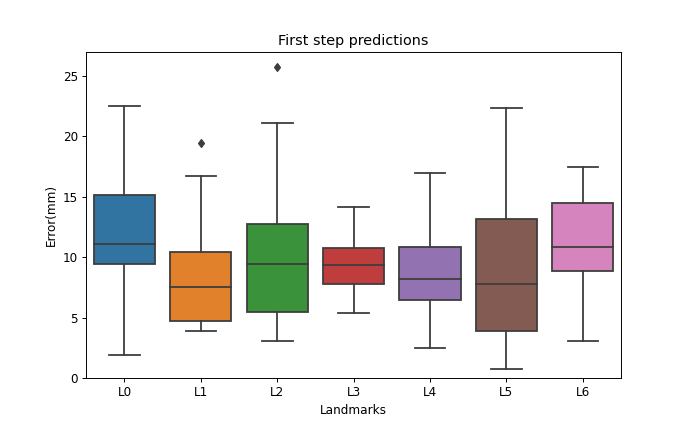

In [11]:
boxplot_1.drop([18,19,20])

# Crear el diagrama de caja
plt.figure(figsize=(8,5))
sns.boxplot(data=boxplot_1)
plt.ylim(0, 27)

plt.title('First step predictions')
plt.xlabel('Landmarks')
plt.ylabel('Error(mm)')
plt.show()

## Boxplot conjunto

<IPython.core.display.Javascript object>


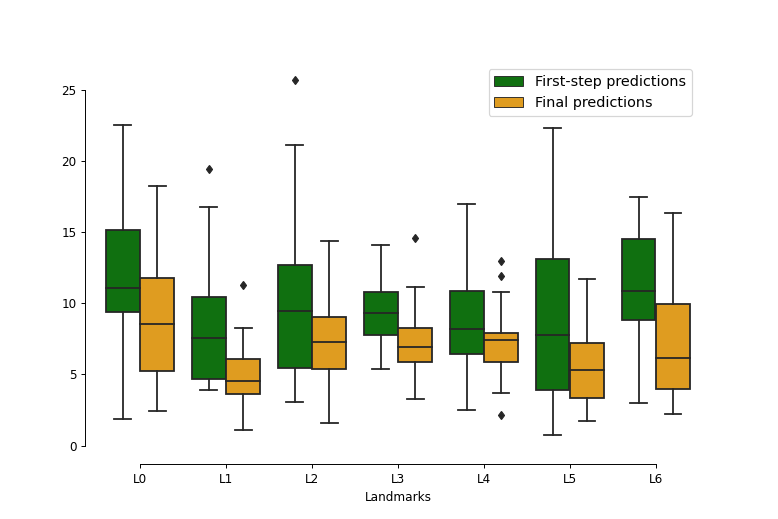

Text(0, 0.5, '')

In [12]:
# Unir ambos dataframes verticalmente
# Dataframe para Final step predictions
df_sub.drop(['Mean', 'Variance', 'Median'])
df_sub1=df_sub.reset_index()
# df_sub1.drop(['index', 'l1', 'l3', 'l4', 'l5','l6'], axis =1, inplace = True)
df_sub1.drop(['index'], axis =1, inplace = True)
df_transformado_sub1 = df_sub1.melt(var_name='Columna', value_name='Valor')
df_transformado_sub1 = df_transformado_sub1.assign(landmarks=df_transformado_sub1['Columna'].str.extract(r'(\d)').astype(int))
df_transformado_sub1['Step'] = 'Final predictions'

# quitando excepciones
# df_sub2.drop(['Mean', 'Variance', 'Median'])
# df_sub22=df_sub2.reset_index()
# df_sub22.drop(['index', 'l1', 'l3', 'l4', 'l5','l6'], axis =1, inplace = True)
# df_transformado_sub22 = df_sub22.melt(var_name='Columna', value_name='Valor')
# df_transformado_sub22 = df_transformado_sub22.assign(landmarks=df_transformado_sub22['Columna'].str.extract(r'(\d)').astype(int))
# df_transformado_sub22['Step'] = 'Final predictions without cropped images'


# Dataframe para FIRST step predictions
df_transformado = boxplot_1.melt(var_name='Columna', value_name='Valor')
df_transformado = df_transformado.assign(landmarks=df_transformado['Columna'].str.extract(r'(\d)').astype(int))
df_transformado['Step'] = 'First-step predictions'

#COMBINED
df_combined = pd.concat([df_transformado, df_transformado_sub1])

# Configurar el tamaño de la figura
plt.figure(figsize=(9,6))

# Crear el boxplot conjunto
sns.boxplot(y = 'Valor', x = 'Columna' , hue="Step", data = df_combined, palette=["g", "orange"]) # , palette=["blue", "red"]
sns.despine(offset=10, trim=True)

# Etiquetas de los ejes
plt.legend(prop = { "size": 12 }, loc ="upper right")
plt.xlabel('Landmarks')
plt.ylabel('')



In [13]:
import numpy as np
import pandas as pd

columns = ['TA diameter', 'Predicted TA diameter', 'TA diameter with networks']
df_TA = pd.DataFrame(columns=columns)

for i in range(len(l3_results)):
    row = []
    
    # Diámetro TA Real
    l3_real = np.array(l3_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    l4_real = np.array(l4_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    row.append(np.linalg.norm(l3_real - l4_real))
    
    # Diámetro TA Predicho
    l3_pred = np.array(l3_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    l4_pred = np.array(l4_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    row.append(np.linalg.norm(l3_pred - l4_pred))
    
    # Diámetro TA Predicho Subred
    l3_subred = np.array(l3_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    l4_subred = np.array(l4_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    row.append(np.linalg.norm(l3_subred - l4_subred))
    
    df_TA.loc[i] = row

df_TA



,TA diameter,Predicted TA diameter,TA diameter with networks
0,137.288163,124.518936,135.502158
1,127.552110,129.244279,131.407257
2,121.261173,122.830352,123.442338
3,116.002372,116.123916,120.532268
4,132.237554,116.903305,126.864971
5,120.650499,116.435549,117.420612
6,133.018156,120.583386,129.548308
7,116.422815,115.551496,116.488703
8,118.348570,116.588167,117.812921
9,123.735412,118.668529,121.378387


<IPython.core.display.Javascript object>


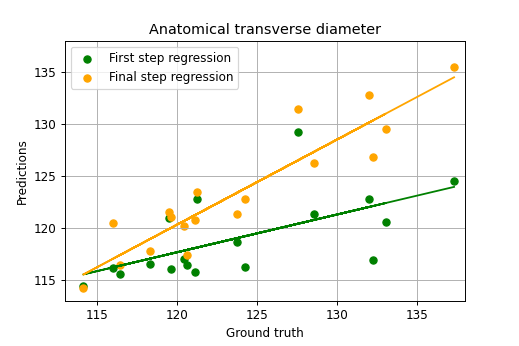

R-squared for first approach: 0.3749262904849172
R-squared for subnetworks approach: 0.8502461074376261


In [17]:
from scipy import stats


x = df_TA['TA diameter']
y = df_TA['TA diameter with networks']

# Creating the scatter plot with different colors
plt.figure(figsize=(6,4))
# Adding a second set of data points
y2 = df_TA['Predicted TA diameter']
# plt.scatter(x, y2, color='red', label='First step predicted transverse diameter')
plt.scatter(x, y2, color='g', label='First step regression')

# Calculating and plotting the regression line for Data Set 2
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x, y2)
line2 = slope2 * x + intercept2
plt.plot(x, line2, color='g')

# Calculating R-squared for Data Set 2
r_squared2 = r_value2 ** 2
print("R-squared for first approach:", r_squared2)



plt.scatter(x, y, color='orange', label='Final step regression')

# Calculating and plotting the regression line for Data Set 1
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
plt.plot(x, line, color='orange')

# Calculating R-squared for Data Set 1
r_squared = r_value ** 2
print("R-squared for subnetworks approach:", r_squared)

plt.grid()  #just add this
plt.ylim(113, 138)
plt.xlim(113, 138)
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Anatomical transverse diameter')
plt.legend()

plt.show()

In [18]:

columns = ['OC diameter', 'Predicted OC diameter', 'OC diameter with subnetworks']
df_OC = pd.DataFrame(columns=columns)

for i in range(len(l3_results)):
    row = []
    
    # Diámetro TA Real
    l5_real = np.array(l5_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    l6_real = np.array(l6_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    row.append(np.linalg.norm(l5_real - l6_real))
    
    # Diámetro TA Predicho
    l5_pred = np.array(l5_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    l6_pred = np.array(l6_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    row.append(np.linalg.norm(l5_pred - l6_pred))
    
    # Diámetro TA Predicho Subred
    l5_subred = np.array(l5_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    l6_subred = np.array(l6_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    row.append(np.linalg.norm(l5_subred - l6_subred))
        
    df_OC.loc[i] = row

df_OC

,OC diameter,Predicted OC diameter,OC diameter with subnetworks
0,110.744249,115.851216,106.082191
1,117.856151,118.506541,114.208535
2,143.634163,126.201003,129.581679
3,124.697251,114.592520,117.248668
4,121.815563,119.592285,101.581969
5,121.449316,115.086811,113.164544
6,124.527004,125.684537,113.572513
7,118.216633,111.858105,109.370865
8,101.476240,117.910825,102.230233
9,130.251365,118.153094,116.118601


<IPython.core.display.Javascript object>


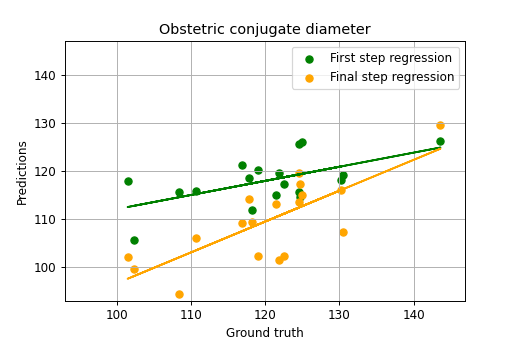

R-squared for first approach: 0.34829904605085305
R-squared for subnetworks approach: 0.5803208490010303


In [20]:

x = df_OC['OC diameter']
y = df_OC['OC diameter with subnetworks']

# Creating the scatter plot with different colors
plt.figure(figsize=(6,4))
# Adding a second set of data points
y2 = df_OC['Predicted OC diameter']
# plt.scatter(x, y2, color='red', label='First step predicted transverse diameter')
plt.scatter(x, y2, color='g', label='First step regression')

# Calculating and plotting the regression line for Data Set 2
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x, y2)
line2 = slope2 * x + intercept2
plt.plot(x, line2, color='g')

# Calculating R-squared for Data Set 2
r_squared2 = r_value2 ** 2
print("R-squared for first approach:", r_squared2)

plt.scatter(x, y, color='orange', label='Final step regression')

# Calculating and plotting the regression line for Data Set 1
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
plt.plot(x, line, color='orange')

# Calculating R-squared for Data Set 1
r_squared = r_value ** 2
print("R-squared for subnetworks approach:", r_squared)


plt.ylim(93, 147)
plt.xlim(93, 147)
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Obstetric conjugate diameter')
plt.legend()
plt.grid()  #just add this


plt.show()

In [21]:
columns = ['Subpubic angle', 'Predicted Subpubic angle', 'Subpubic angle with subnetworks']
df_ANG = pd.DataFrame(columns=columns)

for i in range(len(l3_results)):
    row = []
    
    # Diámetro TA Real
    l0_real = np.array(l0_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    l1_real = np.array(l1_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    l2_real = np.array(l2_results.iloc[i]['Real'].replace('[', '').replace(']', '').split(), dtype=float)
    theta_real = np.degrees(np.arccos(np.dot(l1_real-l0_real, l2_real-l1_real) /
                                 (np.linalg.norm(l1_real-l0_real) * np.linalg.norm(l2_real-l1_real))))
    row.append(theta_real)
    
    # Diámetro TA Predicho
    l0_pred = np.array(l0_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    l1_pred = np.array(l1_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    l2_pred = np.array(l2_results.iloc[i]['Predicted'].replace('[', '').replace(']', '').split(), dtype=float)
    theta_pred = np.degrees(np.arccos(np.dot(l1_pred - l0_pred, l2_pred - l1_pred) /
                                       (np.linalg.norm(l1_pred - l0_pred) * np.linalg.norm(l2_pred - l1_pred))))
    row.append(theta_pred)

    # Diámetro TA Predicho Subred
    l0_subred = np.array(l0_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    l1_subred = np.array(l1_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    l2_subred = np.array(l2_results.iloc[i]['Predicted subred'].replace('[', '').replace(']', '').split(), dtype=float)
    theta_subred = np.degrees(np.arccos(np.dot(l1_subred - l0_subred, l2_subred - l1_subred) /
                                     (np.linalg.norm(l1_subred - l0_subred) * np.linalg.norm(l2_subred - l1_subred))))
    row.append(theta_subred)
        
    df_ANG.loc[i] = row

df_ANG

,Subpubic angle,Predicted Subpubic angle,Subpubic angle with subnetworks
0,88.058534,90.952548,87.747572
1,91.617724,91.527189,91.631732
2,88.057673,91.544313,87.073869
3,80.215632,94.769692,85.011655
4,81.894914,92.148730,85.273203
5,92.915689,95.915743,86.112564
6,86.524845,93.703957,81.587164
7,95.217699,92.673227,89.765900
8,72.298420,93.061223,81.494720
9,67.071850,94.644489,84.672089


<IPython.core.display.Javascript object>


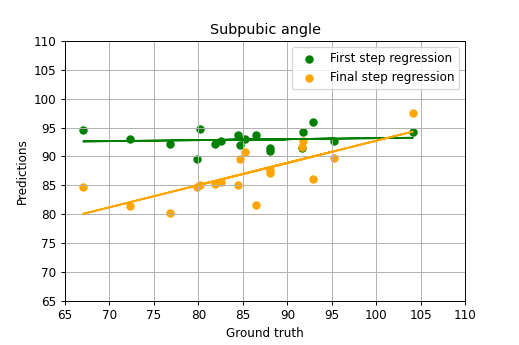

R-squared for first approach: 0.009038653123281918
R-squared for subnetworks approach: 0.5739814103882571


In [23]:
# Assuming you have the DataFrame 'df' with the data

x = df_ANG['Subpubic angle']
y = df_ANG['Subpubic angle with subnetworks']

# Creating the scatter plot with different colors
plt.figure(figsize=(6,4))
# Adding a second set of data points
y2 = df_ANG['Predicted Subpubic angle']
# plt.scatter(x, y2, color='red', label='First step predicted transverse diameter')
plt.scatter(x, y2, color='g', label='First step regression')

# Calculating and plotting the regression line for Data Set 2
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x, y2)
line2 = slope2 * x + intercept2
plt.plot(x, line2, color='g')

# Calculating R-squared for Data Set 2
r_squared2 = r_value2 ** 2
print("R-squared for first approach:", r_squared2)

plt.scatter(x, y, color='orange', label='Final step regression')

# Calculating and plotting the regression line for Data Set 1
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
plt.plot(x, line, color='orange')

# Calculating R-squared for Data Set 1
r_squared = r_value ** 2
print("R-squared for subnetworks approach:", r_squared)


plt.ylim(65, 110)
plt.xlim(65, 110)
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Subpubic angle')
plt.legend()
plt.grid()
plt.show()

In [45]:
df_ANG.drop([2,3,5,10,17], inplace = True)

<IPython.core.display.Javascript object>


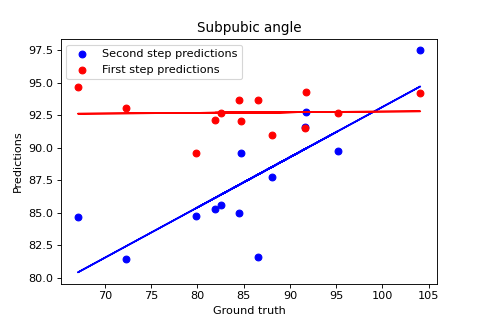

R-squared for Subnetworks approach: 0.6373239414418553
R-squared for First Approach: 0.001073626228165725


In [46]:
# Assuming you have the DataFrame 'df' with the data

x = df_ANG['Subpubic angle']
y = df_ANG['Subpubic angle with subnetworks']

# Creating the scatter plot with different colors
plt.figure(figsize=(6,4))
plt.scatter(x, y, color='blue', label='Second step predictions')

# Calculating and plotting the regression line for Subnetworks
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
plt.plot(x, line, color='blue')

# Calculating R-squared for Subnetworks
r_squared = r_value ** 2
print("R-squared for Subnetworks approach:", r_squared)

# Adding a second set of data points
y2 = df_ANG['Predicted Subpubic angle']
plt.scatter(x, y2, color='red', label='First step predictions')

# Calculating and plotting the regression line for First Approach
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x, y2)
line2 = slope2 * x + intercept2
plt.plot(x, line2, color='red')

# Calculating R-squared for First Approach
r_squared2 = r_value2 ** 2
print("R-squared for First Approach:", r_squared2)

plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Subpubic angle')
plt.legend()

plt.show()